## 1. Loading necessary libraries

In [2]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sweetviz as sv
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns

np.warnings = warnings

In [3]:
import sys
sys.path.append("..")

# import utility functions
import src.utils as util
reload(util)

import src.load_parquet as load_parquet
reload(load_parquet)

# setup OS agnostic pathnames
ROOT_DIR = Path('..')

# Note: to run main notebook from root directory, use:
# ROOT_DIR = Path('')

import src.DataLoader as DataLoader
reload(DataLoader)

dataLoader = DataLoader.DataLoader(ROOT_DIR)

import src.modelling_pipeline as models
reload(models)

mp = models.ModelPipeline(ROOT_DIR)

# import src.utils as util
# reload(util)

# mp = util.util(ROOT_DIR)

In [93]:
# load libraries and modules
import pandas as pd
import numpy as np
import shap

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectFromModel

# model comparison
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# evaluation metrics
from sklearn.metrics import cohen_kappa_score,classification_report 
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, auc, make_scorer
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, balanced_accuracy_score
from sklearn.metrics import PrecisionRecallDisplay

## 2. Loading Data

In [5]:
df_desc_icd, df_desc_labitems, df_desc_items = dataLoader.load_descriptions()
df_diagnoses_icd = dataLoader.load_diagnoses_icd(df_desc_icd)
df_demographic = dataLoader.load_demographic(df_diagnoses_icd)
df_demographic = dataLoader.demographic_clean_AGE(df_demographic)
df_labevents = dataLoader.load_labevents(df_demographic)
df_labevents = dataLoader.labevents_compute_TIME(df_labevents, df_demographic)

Removed 8210 admissions with AGE < 18


In [6]:
columns = ["SUBJECT_ID", "HADM_ID"]
num_unique_combinations = df_demographic.drop_duplicates(subset=columns).shape[0]

print("Number of unique combinations (>18 years old):")
print(num_unique_combinations)

Number of unique combinations (>18 years old):
50766


## 3. Dataset Extraction

In [7]:
hours_list = [0, 1, 2, 3, 4, 5, 6, 7, 8]
top_n_features = [10, 20, 30, 40]

In [8]:
dfs_dict = {}
for top_n in top_n_features:
  dfs_dict[f'top{top_n}'] = {}
  for hour in hours_list:
    feature_filename=ROOT_DIR / 'data/potential_events.csv'
    output_filename = ROOT_DIR / f'data/full_data/t{hour}_top{top_n}.csv'
    dfs_dict[f'top{top_n}'][f't{hour}']=dataLoader.extract_full_data_by_features(df_labevents, df_demographic, df_desc_labitems, hour, feature_filename, top_n, output_filename)


In [9]:
dfs_dict['top40']['t3']

SUBJECT_ID  HADM_ID  AGE  IS_SEPSIS  GENDER_NUM  ITEMID_50804  \
0              22   165315   64          0           1          22.0   
1              23   152223   71          0           0          24.0   
2              23   124321   75          0           0        -999.0   
3              24   161859   39          0           0          27.0   
4              25   129635   58          0           0        -999.0   
...           ...      ...  ...        ...         ...           ...   
50674       98794   190603   78          0           0          21.0   
50675       98797   105447   88          1           0          33.0   
50676       98800   191113   19          0           1          25.0   
50677       98802   101071   83          0           1          18.0   
50678       98805   122631   42          0           0          27.0   

       ITEMID_50809  ITEMID_50813  ITEMID_50818  ITEMID_50820  ...  \
0            -999.0        -999.0          29.0          7.47  ...   
1             112.0        -999.0          34.0          7.45  ...   
2            -999.0        -999.0        -999.0       -999.00  ...   
3            -999.0        -999.0          40.0          7.42  ...   
4            -999.0        -999.0        -999.0       -999.00  ...   
...             ...           ...           ...           ...  ...   
50674         150.0           1.8          30.0          7.44  ...   
50675         163.0           2.6          61.0          7.32  ...   
50676          99.0        -999.0          53.0          7.27  ...   
50677         258.0           3.5          24.0          7.47  ...   
50678         123.0           2.2          53.0          7.29  ...   

       ITEMID_51250  ITEMID_51256  ITEMID_51265  ITEMID_51274  ITEMID_51275  \
0              90.0          62.2         259.0          12.4          30.1   
1            -999.0        -999.0        -999.0        -999.0        -999.0   
2            -999.0        -999.0        -999.0        -999.0        -999.0   
3            -999.0        -999.0        -999.0        -999.0        -999.0   
4              91.0          84.6         269.0          12.8          34.6   
...             ...           ...           ...           ...           ...   
50674        -999.0        -999.0         226.0          15.3          31.2   
50675          87.0        -999.0         184.0          24.1          33.6   
50676          93.0          89.4         151.0          14.3          28.7   
50677          84.0        -999.0         271.0          11.8          23.7   
50678        -999.0        -999.0        -999.0        -999.0        -999.0   

       ITEMID_51277  ITEMID_51279  ITEMID_51301  ITEMID_51493  SOFA  
0              12.6          4.00           5.1           0.0     2  
1            -999.0       -999.00        -999.0        -999.0  -999  
2            -999.0       -999.00        -999.0        -999.0  -999  
3            -999.0       -999.00        -999.0        -999.0  -999  
4              13.0          4.17          12.2        -999.0  -999  
...             ...           ...           ...           ...   ...  
50674        -999.0       -999.00        -999.0        -999.0  -999  
50675          15.8          3.41           6.2        -999.0  -999  
50676          12.7          3.15          15.1        -999.0  -999  
50677          14.1          5.03          30.3        -999.0  -999  
50678        -999.0       -999.00        -999.0        -999.0  -999  

[50679 rows x 46 columns]

## 4. Data processing

### 4.1 Missing values

In [10]:
# Number and proportion of missing values in overall dataset
mp.count_missing_values_all(dfs_dict, hours_list, top_n_features)

top10_features_NA_Count top10_features_NA_% top20_features_NA_Count  \
t0                  337938              39.19%                  655171   
t1                  281873              32.70%                  552885   
t2                  252276              29.27%                  501521   
t3                  229446              26.63%                  461332   
t4                  209346              24.31%                  425678   
t5                  191785              22.28%                  393840   
t6                  177380              20.63%                  366778   
t7                  165824              19.31%                  344198   
t8                  156133              18.21%                  325172   

   top20_features_NA_% top30_features_NA_Count top30_features_NA_%  \
t0              49.68%                 1022882              56.02%   
t1              41.93%                  881229              48.27%   
t2              38.05%                  808140              44.28%   
t3              35.01%                  751050              41.17%   
t4              32.32%                  701282              38.46%   
t5              29.92%                  657403              36.07%   
t6              27.89%                  620056              34.05%   
t7              26.21%                  588585              32.37%   
t8              24.80%                  561948              30.95%   

   top40_features_NA_Count top40_features_NA_%  
t0                 1368814              59.97%  
t1                 1194105              52.33%  
t2                 1104934              48.43%  
t3                 1035111              45.39%  
t4                  974102              42.74%  
t5                  920375              40.40%  
t6                  874361              38.42%  
t7                  835039              36.74%  
t8                  801458              35.32%

From the above, we have computed the number and proportion of missing values in the dataset across different number of top features (from 10 to 40) in t0 to t8. We will further analyse the number and proportion of missing values specific to sepsis admissions.

In [11]:
# Number and proportion of missing values in sepsis admission
mp.count_missing_values_all(dfs_dict, hours_list, top_n_features, sepsis_only=True)

top10_features_NA_Count top10_features_NA_% top20_features_NA_Count  \
t0                   26940              30.64%                   55627   
t1                   18263              20.78%                   39379   
t2                   14761              16.80%                   33233   
t3                   12407              14.13%                   28999   
t4                   10772              12.28%                   25963   
t5                    9605              10.95%                   23594   
t6                    8706               9.93%                   21617   
t7                    7969               9.10%                   19884   
t8                    7265               8.31%                   18297   

   top20_features_NA_% top30_features_NA_Count top30_features_NA_%  \
t0              41.37%                   89066              47.84%   
t1              29.29%                   67062              36.02%   
t2              24.73%                   58291              31.33%   
t3              21.59%                   52140              28.04%   
t4              19.34%                   47657              25.65%   
t5              17.58%                   44081              23.73%   
t6              16.13%                   41081              22.13%   
t7              14.85%                   38471              20.75%   
t8              13.68%                   36091              19.49%   

   top40_features_NA_Count top40_features_NA_%  
t0                  120444              51.75%  
t1                   93738              40.28%  
t2                   83045              35.70%  
t3                   75523              32.49%  
t4                   69909              30.10%  
t5                   65349              28.14%  
t6                   61368              26.45%  
t7                   57893              24.99%  
t8                   54731              23.65%

From the above, we can observe for sepsis admissions there is significant decrease in missing values from t0 to t1 (approximately 10% decrease), which is likely due to the patients receive their first blood test within an hour. This finding is align to the findings on the mean of first blood test performed in sepsis admissions to be 0.84 hours.

As at t4, there are less than 30% of missing values observed in the sepsis admissions. We believe focusing our traditional ML mdoel training to predict sepsis within 4 hours after admission is reasonable. 

In [12]:
# Number and proportion of missing SOFA in all admission
mp.count_missing_SOFA(dfs_dict, hours_list)

SOFA_NA_Count SOFA_NA_%
t0         39568    78.02%
t1         36742    72.45%
t2         35110    69.25%
t3         33783    66.66%
t4         32728    64.62%
t5         31871    62.96%
t6         31045    61.38%
t7         30262    59.92%
t8         29525    58.55%

In [13]:
# Number and proportion of missing SOFA in sepsis admission
mp.count_missing_SOFA(dfs_dict, hours_list, sepsis_only=True)

SOFA_NA_Count SOFA_NA_%
t0          3149    60.89%
t1          2618    50.63%
t2          2375    45.95%
t3          2185    42.30%
t4          2032    39.36%
t5          1918    37.16%
t6          1789    34.70%
t7          1685    32.72%
t8          1590    30.92%

Referring to the literatures, we have noted that SOFA is broadly applied to obtain reliable indicator of sepsis. In our project, we tried to compute SOFA score on the admissions in MIMIC III dataset. However, owing to the limitation on variables, we were not able to collect sufficient data to compute SOFA scores for every admission. 

From the above, as at t4, we were managed to compute SOFA score for approximately 40% of total admissions and 60% of sepsis admissions.

In [14]:
def filter_missing_rows(df, proportion_to_return):
    """
    Filters rows in a DataFrame based on a threshold of missing or masked values.

    This function checks each row in the input DataFrame for missing or masked values. 
    Missing values are identified as NaN, while masked values are represented as -999. 
    The function calculates the percentage of missing or masked values in each row. 
    Rows with a percentage of missing or masked values less than or equal to the specified 
    'proportion_to_return' are retained in the returned DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame with potential missing or masked values.
    proportion_to_return (float): The threshold percentage (0-100) of allowable missing or 
                                   masked values per row. Rows with a percentage of missing 
                                   or masked values within this threshold are returned.

    Returns:
    pd.DataFrame: A DataFrame consisting of rows from the input DataFrame that have a 
                  percentage of missing or masked values less than or equal to the 
                  'proportion_to_return'. If no masking is present, the function checks 
                  for NaN values instead.
    """
    # Check if masking has been applied
    if (df == -999).any().any():  # Masking is present
        count_missing = (df == -999).sum(axis=1)
    else:  # No masking, check for NaN
        count_missing = df.isna().sum(axis=1)

    # Calculate the percentage of missing values for each row
    p_missing = count_missing / df.shape[1] * 100

    # Filter rows based on the allowed proportion of missing/masked values
    return df[p_missing <= proportion_to_return]

In [15]:
# Iterate through all dataframes in dfs_dict and update them
dfs_dict_without_missing = {}
for key in dfs_dict.keys():
    dfs_dict_without_missing[key] = {}
    for subkey in dfs_dict[key].keys():
        dfs_dict_without_missing[key][subkey] = filter_missing_rows(dfs_dict[key][subkey], 70)
        dfs_dict_without_missing[key][subkey]= dfs_dict_without_missing[key][subkey].drop(['SUBJECT_ID', 'HADM_ID'], axis=1)

In [16]:
dfs_dict_without_missing['top40']['t3']

AGE  IS_SEPSIS  GENDER_NUM  ITEMID_50804  ITEMID_50809  ITEMID_50813  \
0       64          0           1          22.0        -999.0        -999.0   
4       58          0           0        -999.0        -999.0        -999.0   
8       72          0           0          27.0        -999.0           1.4   
10      82          0           0        -999.0        -999.0           3.0   
11      65          0           0          23.0        -999.0        -999.0   
...    ...        ...         ...           ...           ...           ...   
50673   53          0           0        -999.0        -999.0           3.3   
50674   78          0           0          21.0         150.0           1.8   
50675   88          1           0          33.0         163.0           2.6   
50676   19          0           1          25.0          99.0        -999.0   
50677   83          0           1          18.0         258.0           3.5   

       ITEMID_50818  ITEMID_50820  ITEMID_50821  ITEMID_50861  ...  \
0              29.0          7.47         287.0          19.0  ...   
4            -999.0       -999.00        -999.0        -999.0  ...   
8              36.0          7.47         148.0          32.0  ...   
10           -999.0       -999.00        -999.0          18.0  ...   
11             33.0          7.43          53.0        -999.0  ...   
...             ...           ...           ...           ...  ...   
50673        -999.0       -999.00        -999.0        -999.0  ...   
50674          30.0          7.44         456.0        -999.0  ...   
50675          61.0          7.32         193.0        -999.0  ...   
50676          53.0          7.27         433.0        -999.0  ...   
50677          24.0          7.47         227.0        -999.0  ...   

       ITEMID_51250  ITEMID_51256  ITEMID_51265  ITEMID_51274  ITEMID_51275  \
0              90.0          62.2         259.0          12.4          30.1   
4              91.0          84.6         269.0          12.8          34.6   
8             102.0        -999.0         109.0          13.2          29.4   
10             90.0          81.0         503.0          13.3          26.4   
11             89.0        -999.0         299.0          12.3          25.0   
...             ...           ...           ...           ...           ...   
50673          87.0          73.0         195.0          15.9          29.1   
50674        -999.0        -999.0         226.0          15.3          31.2   
50675          87.0        -999.0         184.0          24.1          33.6   
50676          93.0          89.4         151.0          14.3          28.7   
50677          84.0        -999.0         271.0          11.8          23.7   

       ITEMID_51277  ITEMID_51279  ITEMID_51301  ITEMID_51493  SOFA  
0              12.6          4.00           5.1           0.0     2  
4              13.0          4.17          12.2        -999.0  -999  
8              14.7          2.94           6.9          12.0     3  
10             13.2          4.08          28.3        -999.0     0  
11             13.5          4.55          11.1        -999.0  -999  
...             ...           ...           ...           ...   ...  
50673          13.9          4.58          25.4        -999.0  -999  
50674        -999.0       -999.00        -999.0        -999.0  -999  
50675          15.8          3.41           6.2        -999.0  -999  
50676          12.7          3.15          15.1        -999.0  -999  
50677          14.1          5.03          30.3        -999.0  -999  

[39341 rows x 44 columns]

<Figure size 1500x700 with 0 Axes>

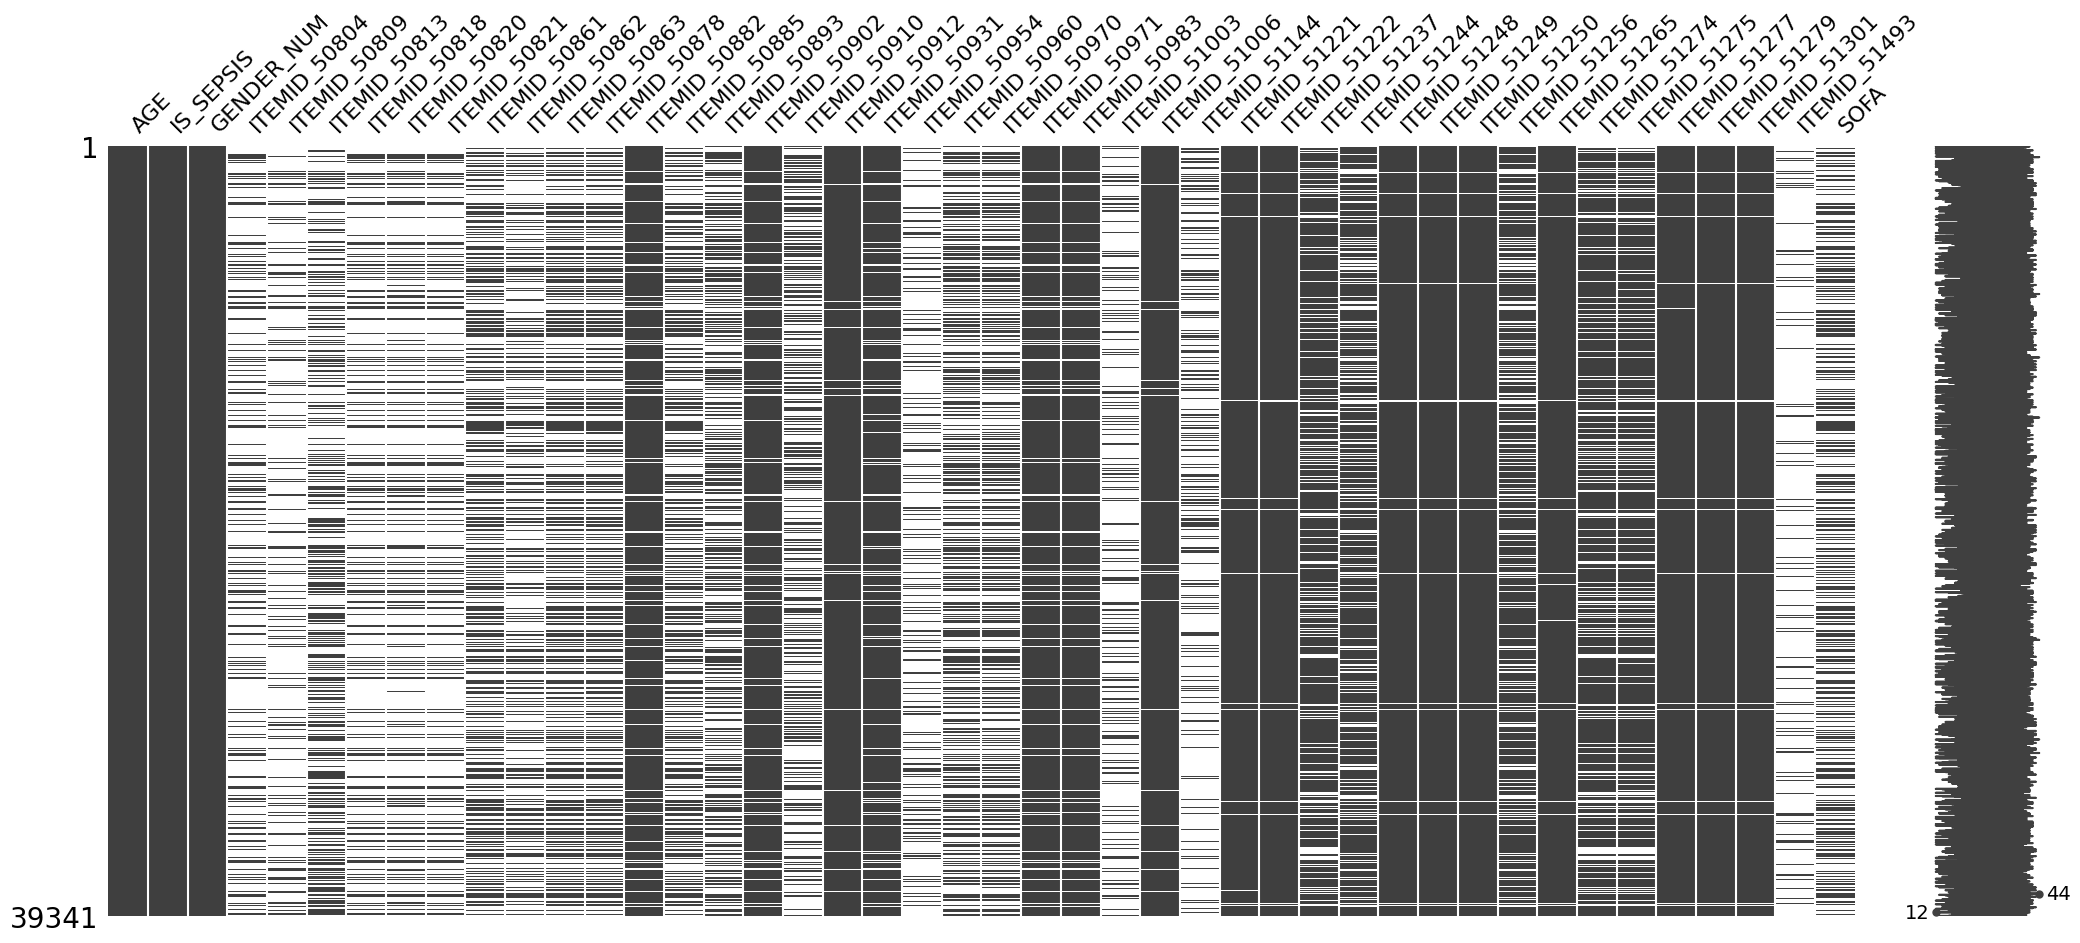

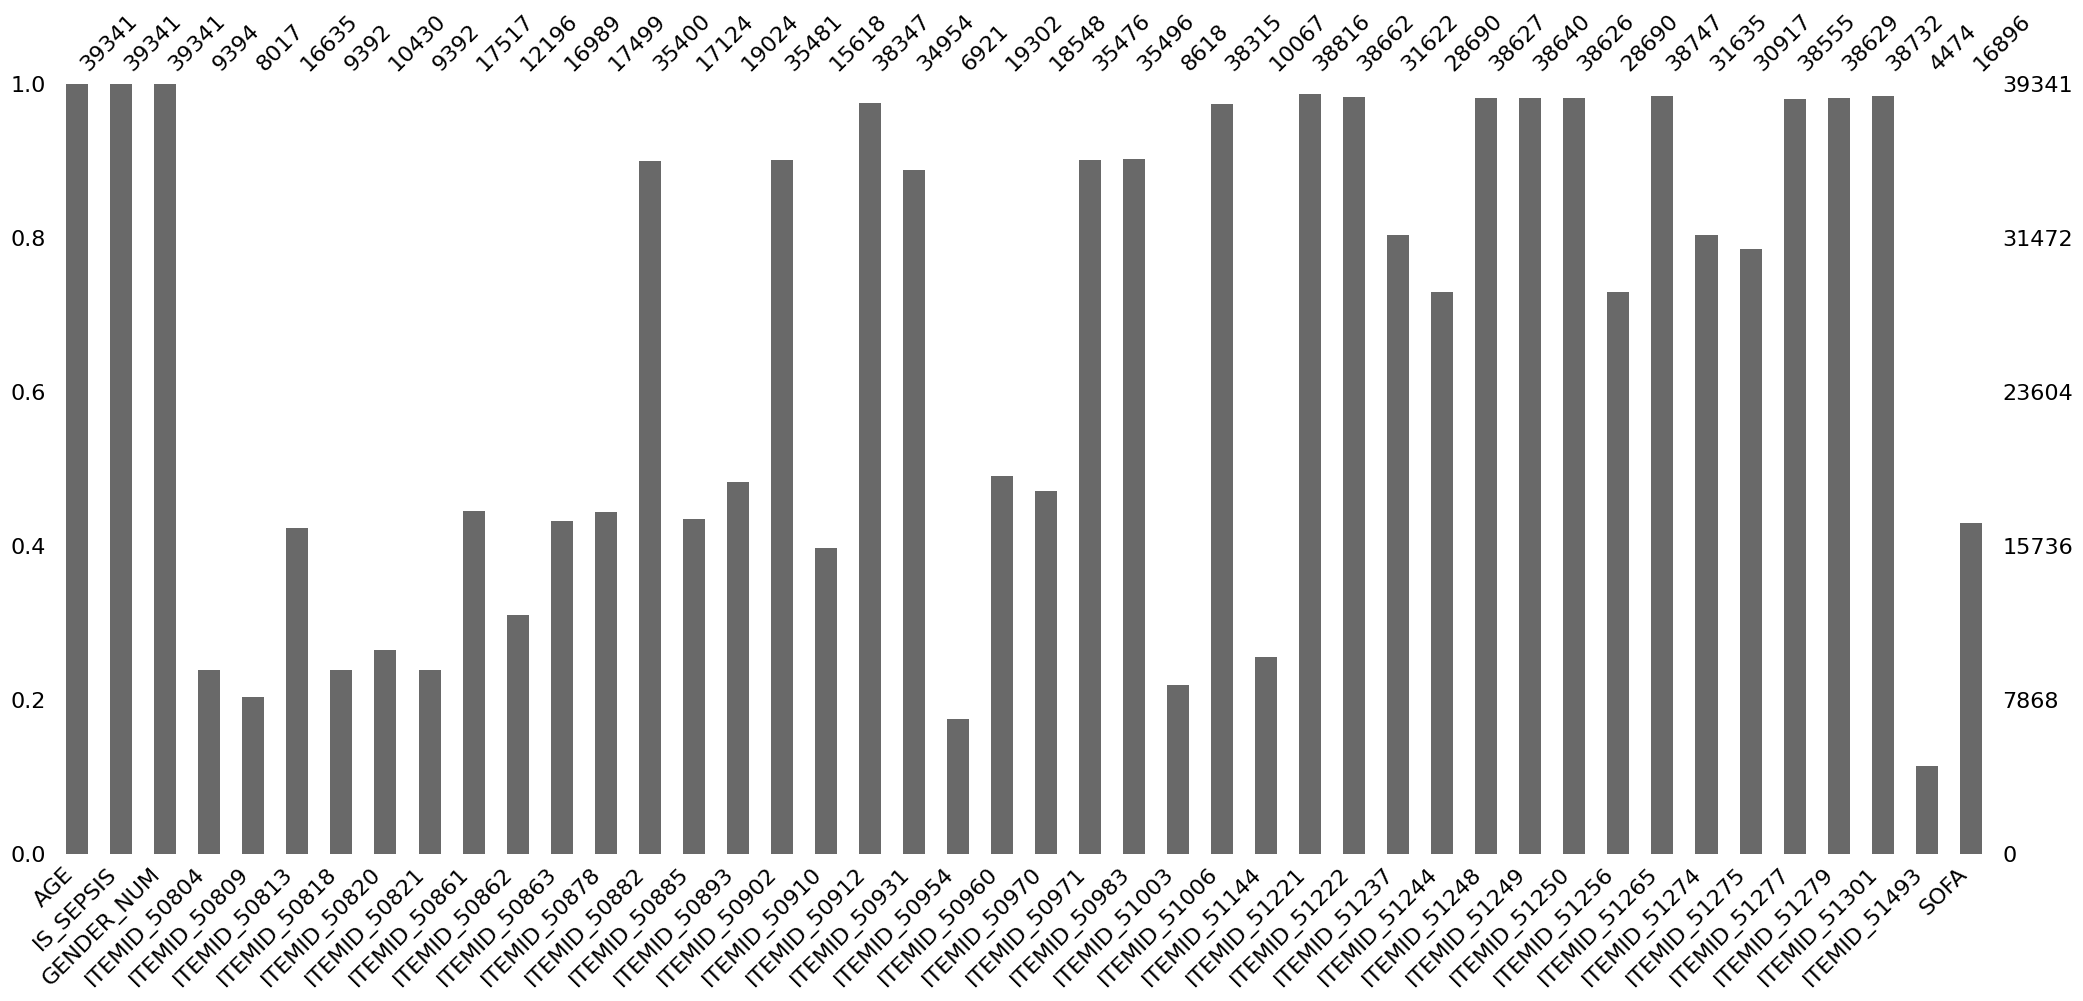

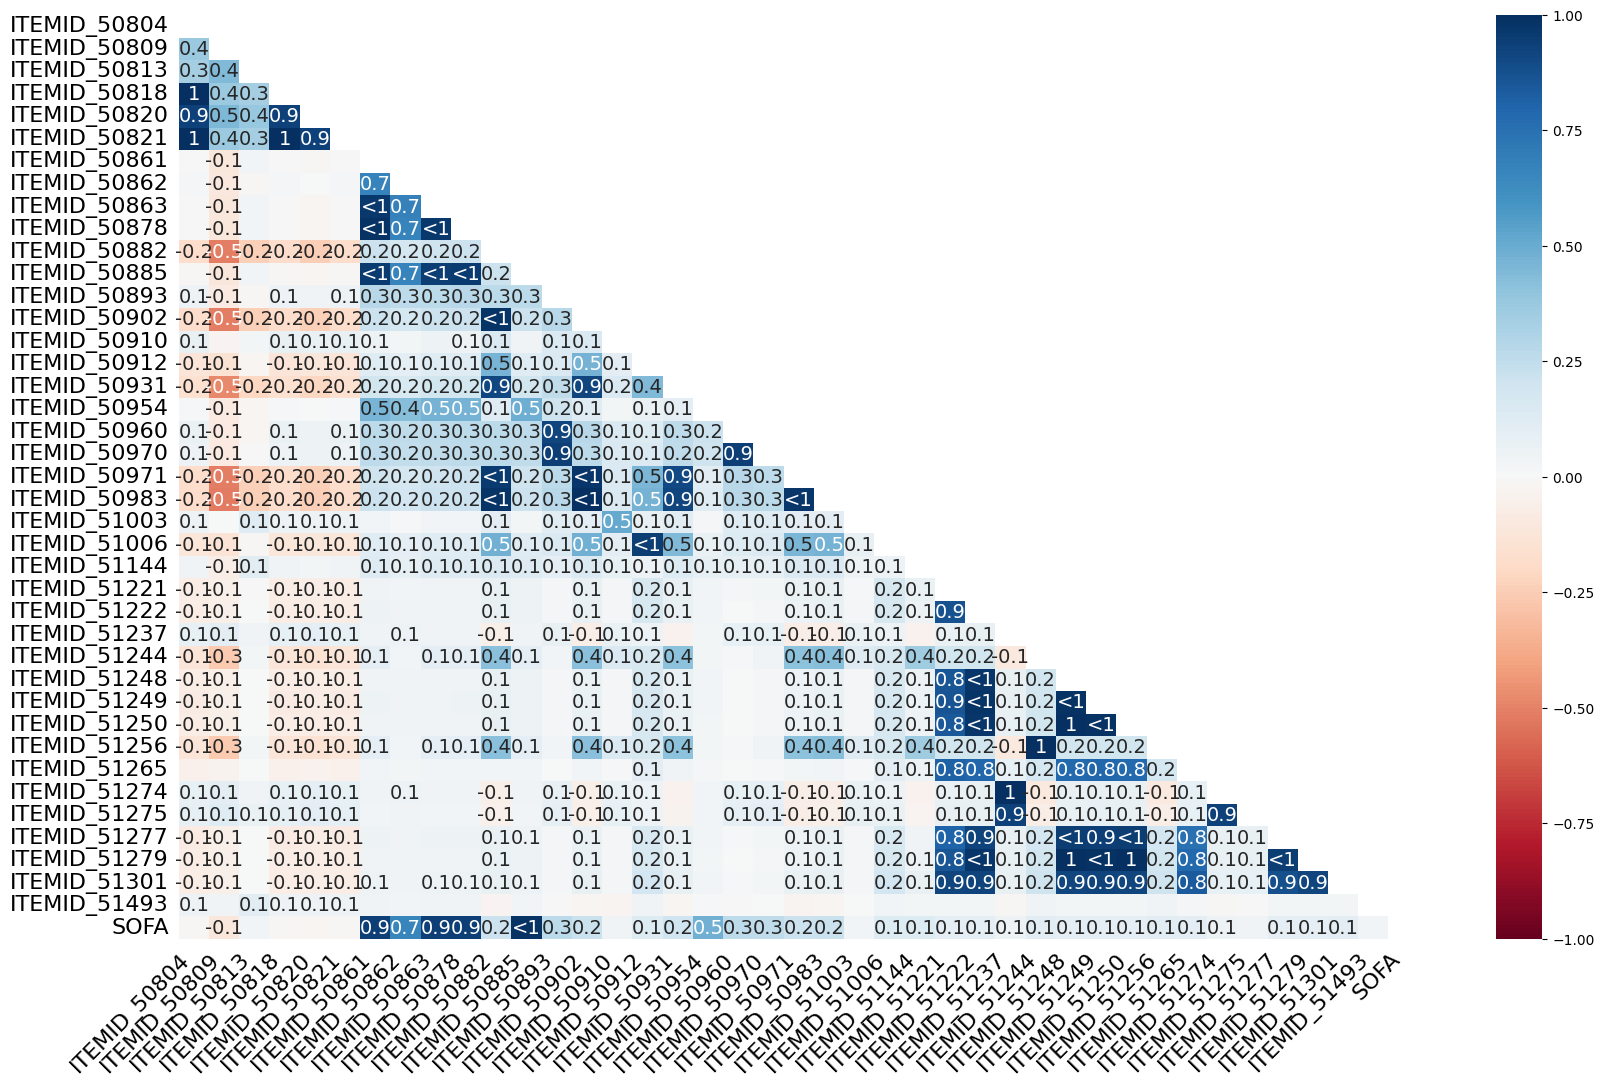

In [17]:
import missingno as msno
import matplotlib.pyplot as plt

def visualise_missing_data(df):
    """
    Convert non-standard missing values (-999) to NaN and visualize the missing data using missingno,
    without altering the original DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the dataset.

    Returns:
        None
    """

    # Create a copy of the DataFrame to avoid changing the original
    df_copy = df.copy()

    # Replace -999 with NaN in the copy
    df_copy.replace(-999, np.nan, inplace=True)

    plt.figure(figsize=(15, 7)) 

    # Create a matrix plot for missing values
    msno.matrix(df_copy)
    plt.show()

    # Create a bar plot for missing values
    msno.bar(df_copy)
    plt.show()

    # Create a heatmap for missing values
    msno.heatmap(df_copy)
    plt.show()

visualise_missing_data(dfs_dict_without_missing['top40']['t3'])

In [18]:
dfs_top40_t3_sepsis = dfs_dict_without_missing['top40']['t3']
dfs_top40_t3_sepsis = dfs_top40_t3_sepsis[dfs_top40_t3_sepsis["IS_SEPSIS"] == 1]
dfs_top40_t3_sepsis

AGE  IS_SEPSIS  GENDER_NUM  ITEMID_50804  ITEMID_50809  ITEMID_50813  \
18      75          1           0        -999.0        -999.0        -999.0   
21      63          1           0        -999.0        -999.0        -999.0   
22      63          1           0        -999.0        -999.0           1.5   
53      55          1           0        -999.0        -999.0        -999.0   
54      68          1           0          24.0        -999.0           2.3   
...    ...        ...         ...           ...           ...           ...   
50639   45          1           0        -999.0        -999.0           1.8   
50648   84          1           1        -999.0         107.0           1.0   
50653   69          1           0        -999.0        -999.0        -999.0   
50672   80          1           1          16.0         119.0           2.9   
50675   88          1           0          33.0         163.0           2.6   

       ITEMID_50818  ITEMID_50820  ITEMID_50821  ITEMID_50861  ...  \
18           -999.0       -999.00        -999.0         112.0  ...   
21           -999.0       -999.00        -999.0          38.0  ...   
22           -999.0       -999.00        -999.0         127.0  ...   
53           -999.0       -999.00        -999.0          39.0  ...   
54             37.0          7.40          35.0          15.0  ...   
...             ...           ...           ...           ...  ...   
50639        -999.0       -999.00        -999.0          11.0  ...   
50648        -999.0       -999.00        -999.0        -999.0  ...   
50653        -999.0       -999.00        -999.0          15.0  ...   
50672          41.0          7.17         256.0          19.0  ...   
50675          61.0          7.32         193.0        -999.0  ...   

       ITEMID_51250  ITEMID_51256  ITEMID_51265  ITEMID_51274  ITEMID_51275  \
18             94.0        -999.0          76.0          14.4          28.2   
21             87.0          62.9          91.0        -999.0        -999.0   
22            105.0          76.3         109.0          15.9          29.8   
53             94.0          90.0          24.0        -999.0        -999.0   
54             93.0          78.0         144.0          13.7          31.6   
...             ...           ...           ...           ...           ...   
50639          81.0          70.0         644.0          16.0          33.5   
50648          96.0          82.5         197.0        -999.0        -999.0   
50653          83.0          94.6         213.0          15.1          24.4   
50672         101.0          88.5         164.0          11.8          51.5   
50675          87.0        -999.0         184.0          24.1          33.6   

       ITEMID_51277  ITEMID_51279  ITEMID_51301  ITEMID_51493  SOFA  
18             14.0          3.82          18.2        -999.0     6  
21             16.0          3.44           4.5        -999.0     4  
22             14.9          3.00           5.0        -999.0     5  
53             19.8          2.81           1.6        -999.0     4  
54             13.5          3.38           3.4        -999.0     3  
...             ...           ...           ...           ...   ...  
50639          16.4          4.21          24.7        -999.0     1  
50648          14.5          2.46           7.0        -999.0  -999  
50653          17.5          3.33          12.9        -999.0     5  
50672          13.3          2.85          13.3        -999.0     4  
50675          15.8          3.41           6.2        -999.0  -999  

[4672 rows x 44 columns]

<Figure size 1500x700 with 0 Axes>

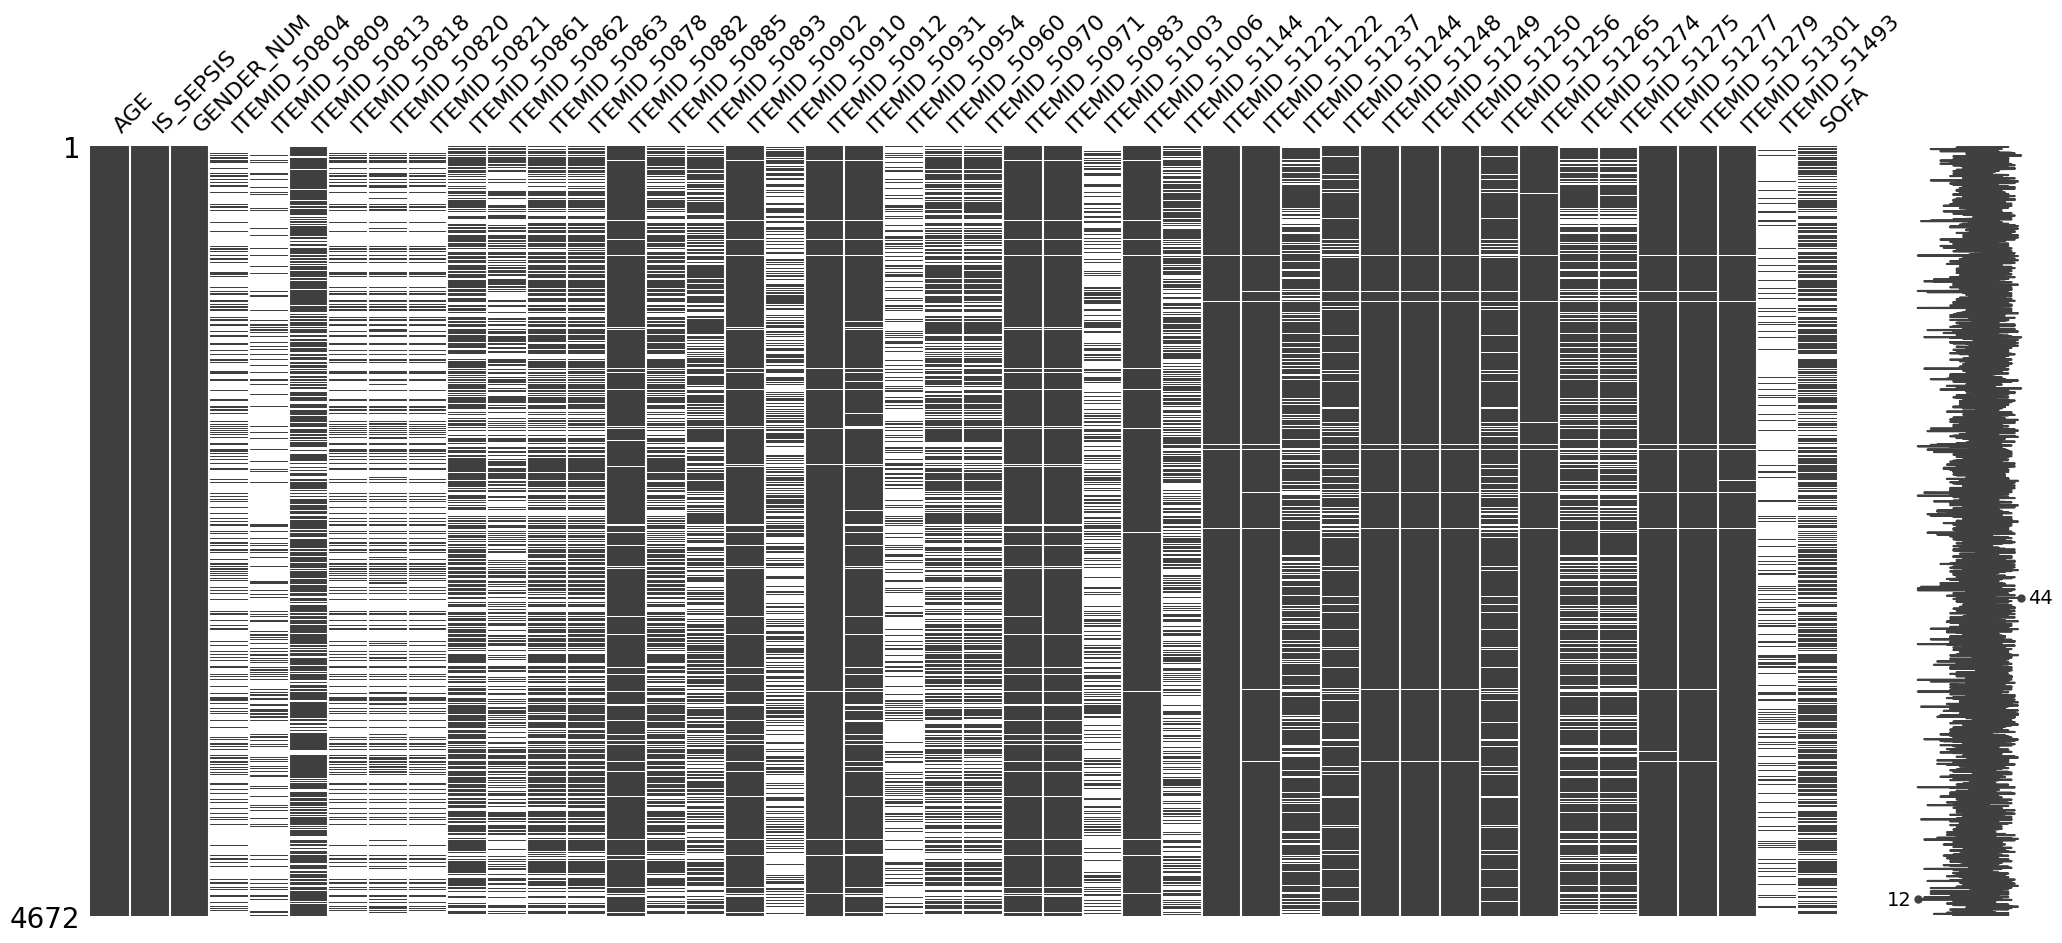

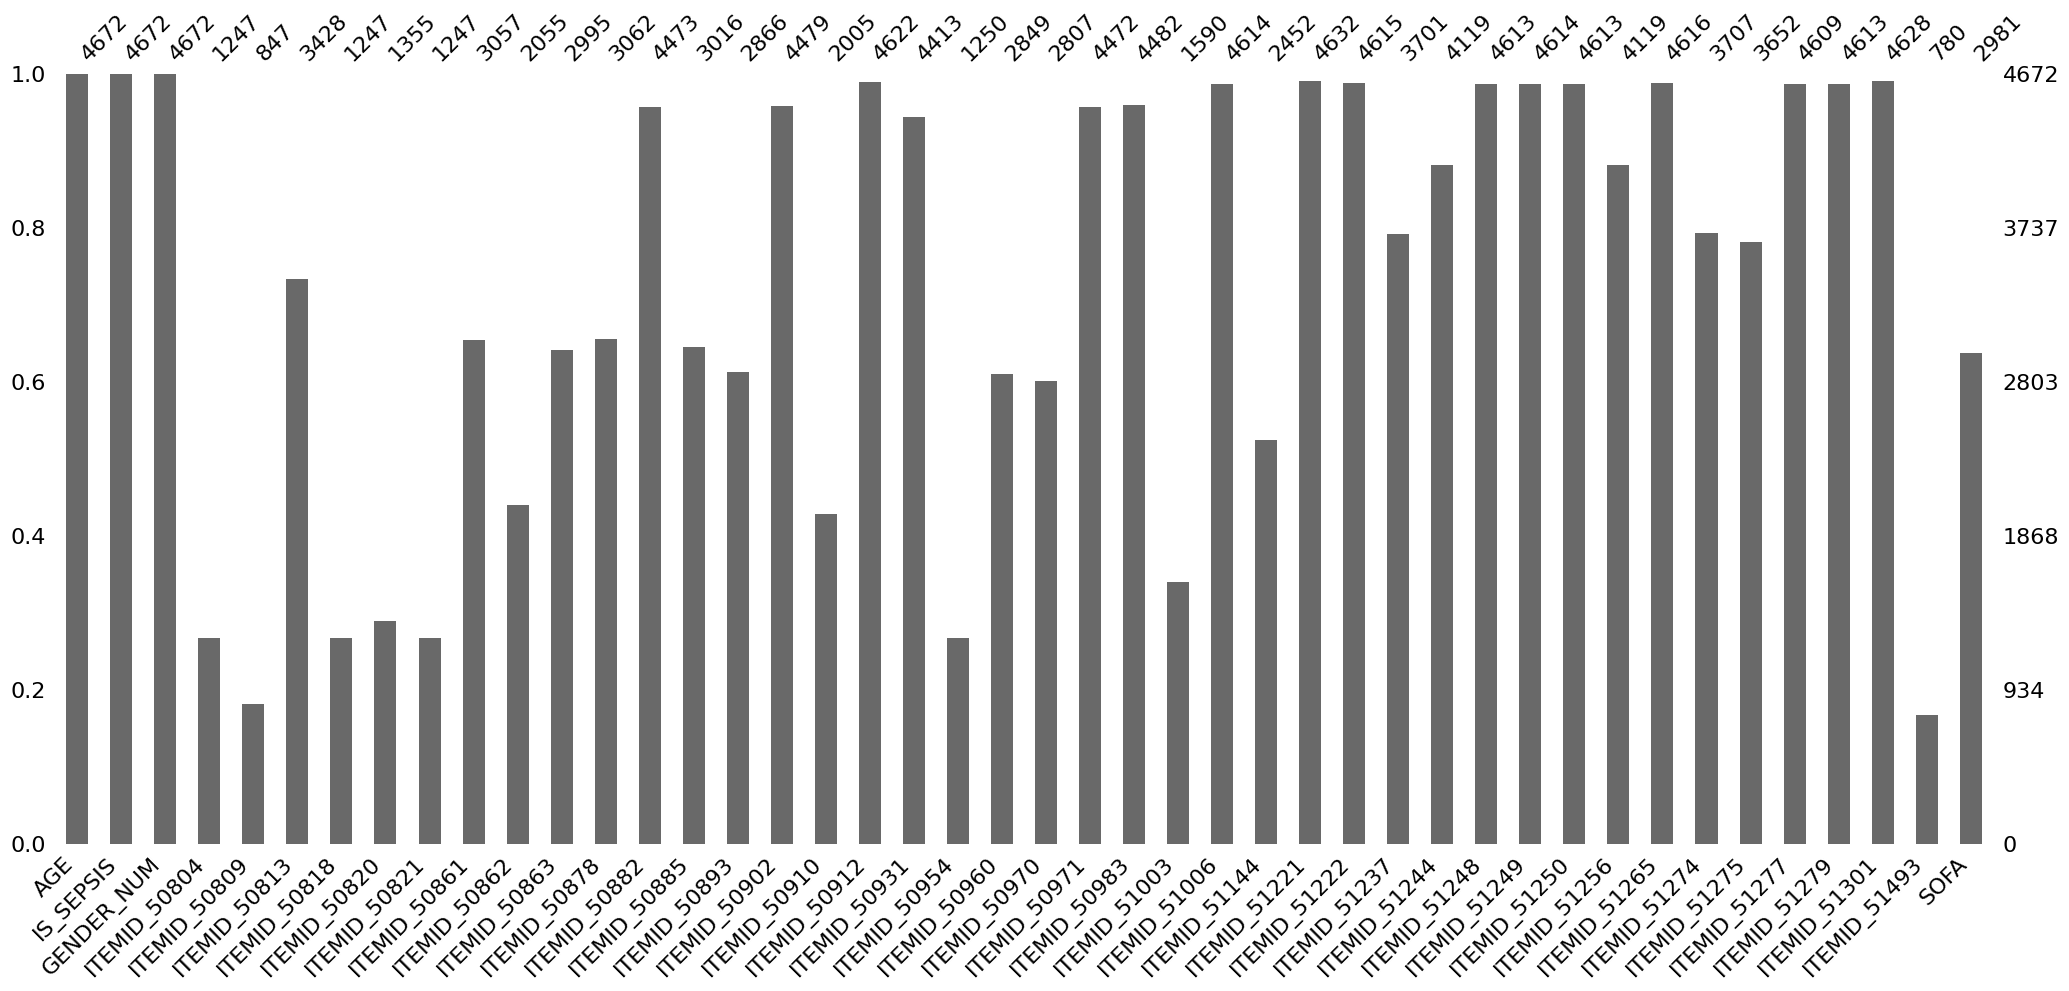

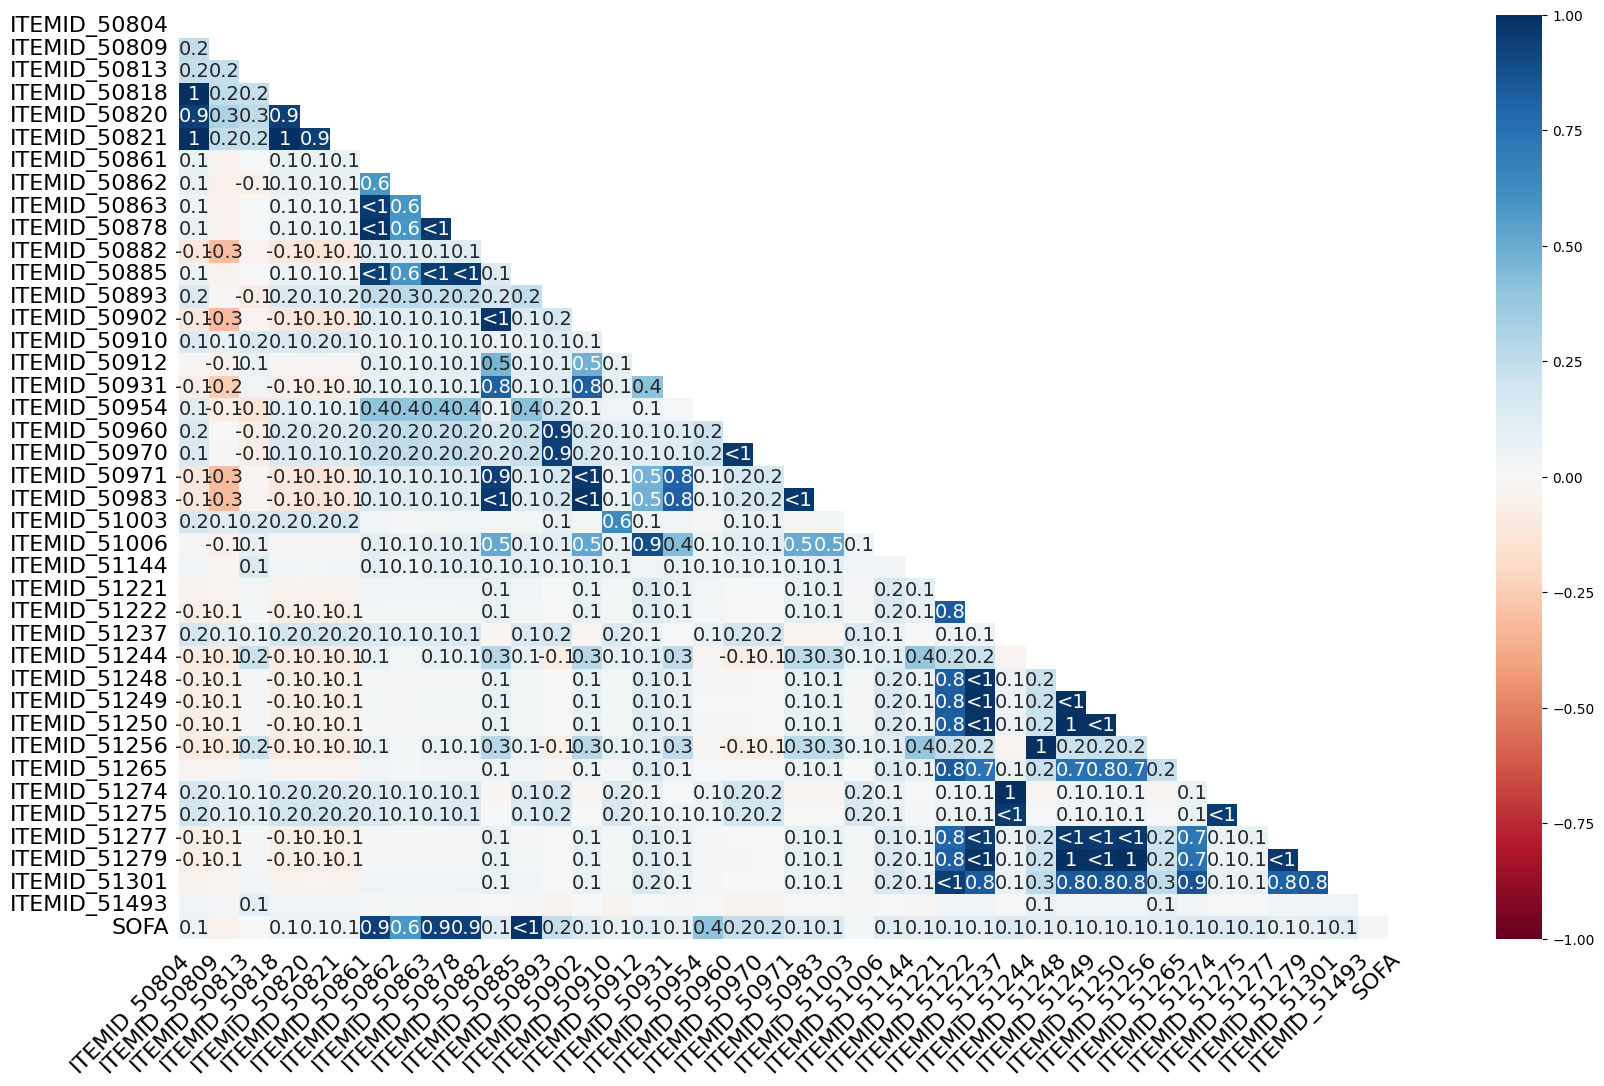

In [19]:
visualise_missing_data(dfs_top40_t3_sepsis)

## 5. Model Fitting

In this section, we fitted all three traditional (static) Machine Learning algorithms for different top features (top 10 features to top 40 features) and time windows (t0 to t4). We then evaluated and compared the performance of all the models to search for the best combination of traditional machine learning algorithm, top features extraction, and time window.

In [20]:
top_features = ['top10', 'top20', 'top30', 'top40'] 
time_windows = ['t0', 't1', 't2', 't3', 't4']

In [21]:
split_data_dict = {} # Dictionary to store split datasets
models_dict = {}  # Dictionary to store candidate models for each top and time
performance_dict = {}
consolidated_performance = {}
all_performance_dfs = []

for top in top_features:
    performance_dict[top] = {}
    models_dict[top] = {}  # Initialize a sub-dictionary for this top value
    dfs_list = []
    
    for time in time_windows:
        # Split data
        X_train, X_test, y_train, y_test = mp.split_data(dfs_dict_without_missing[top][time])
        
        # Store split data
        split_data_dict[(top, time)] = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}
        
        # Get class weights
        current_class_weights = mp.get_class_weights(y_train)
        
        # Initialize models
        candidate_models = {
            'Logistic_Regression': LogisticRegression(max_iter=10000000000, class_weight=current_class_weights, C=0.1, penalty=None, random_state=901),
            'Random_Forest': RandomForestClassifier(class_weight=current_class_weights, max_depth=7, min_samples_leaf=25, min_samples_split=250, random_state=901),
            'Gradient_Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=901)
        }

        # Store candidate models
        models_dict[top][time] = candidate_models
        
        # Compute performance
        performance_df = mp.static_models(candidate_models, current_class_weights, X_train, y_train, X_test, y_test, time)
        performance_df['top_features'] = top

        # Store performance
        performance_dict[top][time] = performance_df
        
        # Append to the list
        dfs_list.append(performance_df)
    
    # Concatenate and sort for this top value
    consolidated_df = pd.concat(dfs_list)
    consolidated_df = consolidated_df.sort_values(by='Model')
    consolidated_df.reset_index(drop=True, inplace=True)
    
    # Append to the all_dfs list
    all_performance_dfs.append(consolidated_df)

#concatenate all the dataframes into one
all_performance_df = pd.concat(all_performance_dfs, ignore_index=True)
all_performance_df = all_performance_df[['top_features'] + [col for col in all_performance_df.columns if col != 'top_features']]

Setting penalty=None will ignore the C and l1_ratio parameters
The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
Setting penalty=None will ignore the C and l1_ratio parameters
The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
Setting penalty=None will ignore the C and l1_ratio parameters
The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries bef

# 6. Model Evaluation

In [22]:
all_performance_df

top_features                   Model  Balanced_Acc_Train  \
0         top10    Gradient_Boosting_t0            0.560945   
1         top10    Gradient_Boosting_t1            0.557429   
2         top10    Gradient_Boosting_t2            0.566528   
3         top10    Gradient_Boosting_t3            0.559590   
4         top10    Gradient_Boosting_t4            0.560878   
5         top10  Logistic_Regression_t0            0.642489   
6         top10  Logistic_Regression_t1            0.648852   
7         top10  Logistic_Regression_t2            0.653882   
8         top10  Logistic_Regression_t3            0.645229   
9         top10  Logistic_Regression_t4            0.652378   
10        top10        Random_Forest_t0            0.740297   
11        top10        Random_Forest_t1            0.738618   
12        top10        Random_Forest_t2            0.742136   
13        top10        Random_Forest_t3            0.738878   
14        top10        Random_Forest_t4            0.745479   
15        top20    Gradient_Boosting_t0            0.571939   
16        top20    Gradient_Boosting_t1            0.605502   
17        top20    Gradient_Boosting_t2            0.601914   
18        top20    Gradient_Boosting_t3            0.594441   
19        top20    Gradient_Boosting_t4            0.591945   
20        top20  Logistic_Regression_t0            0.655557   
21        top20  Logistic_Regression_t1            0.718294   
22        top20  Logistic_Regression_t2            0.722536   
23        top20  Logistic_Regression_t3            0.717669   
24        top20  Logistic_Regression_t4            0.721126   
25        top20        Random_Forest_t0            0.747879   
26        top20        Random_Forest_t1            0.769983   
27        top20        Random_Forest_t2            0.772519   
28        top20        Random_Forest_t3            0.769046   
29        top20        Random_Forest_t4            0.772068   
30        top30    Gradient_Boosting_t0            0.577090   
31        top30    Gradient_Boosting_t1            0.610874   
32        top30    Gradient_Boosting_t2            0.606094   
33        top30    Gradient_Boosting_t3            0.600670   
34        top30    Gradient_Boosting_t4            0.599171   
35        top30  Logistic_Regression_t0            0.656922   
36        top30  Logistic_Regression_t1            0.714957   
37        top30  Logistic_Regression_t2            0.722637   
38        top30  Logistic_Regression_t3            0.719244   
39        top30  Logistic_Regression_t4            0.722531   
40        top30        Random_Forest_t0            0.745488   
41        top30        Random_Forest_t1            0.770713   
42        top30        Random_Forest_t2            0.776783   
43        top30        Random_Forest_t3            0.777753   
44        top30        Random_Forest_t4            0.773931   
45        top40    Gradient_Boosting_t0            0.594912   
46        top40    Gradient_Boosting_t1            0.631002   
47        top40    Gradient_Boosting_t2            0.626489   
48        top40    Gradient_Boosting_t3            0.617483   
49        top40    Gradient_Boosting_t4            0.618932   
50        top40  Logistic_Regression_t0            0.690663   
51        top40  Logistic_Regression_t1            0.733271   
52        top40  Logistic_Regression_t2            0.735697   
53        top40  Logistic_Regression_t3            0.731794   
54        top40  Logistic_Regression_t4            0.739140   
55        top40        Random_Forest_t0            0.761249   
56        top40        Random_Forest_t1            0.778459   
57        top40        Random_Forest_t2            0.779073   
58        top40        Random_Forest_t3            0.778277   
59        top40        Random_Forest_t4            0.781338   

    Balanced_Acc_Test  Precision_Train  Precision_Test  Recall_Train  \
0            0.559166         0.645439        0.613333      0.131395   
1            0.

In [23]:
all_performance_top40_t3_df = all_performance_df.loc[
    (all_performance_df['top_features'] == "top40") & 
    (all_performance_df['Model'].str.contains('t3'))
]
all_performance_top40_t3_df = all_performance_top40_t3_df.reset_index(drop=True)
all_performance_top40_t3_df

top_features                   Model  Balanced_Acc_Train  Balanced_Acc_Test  \
0        top40    Gradient_Boosting_t3            0.617483           0.609255   
1        top40  Logistic_Regression_t3            0.731794           0.740603   
2        top40        Random_Forest_t3            0.778277           0.763997   

   Precision_Train  Precision_Test  Recall_Train  Recall_Test  F1_Train  \
0         0.704236        0.625352      0.249064     0.237687  0.367984   
1         0.271068        0.281430      0.727127     0.733405  0.394915   
2         0.311691        0.304664      0.792402     0.762313  0.447398   

    F1_Test  AUROC_Train  AUROC_Test  
0  0.344453     0.866056    0.849169  
1  0.406770     0.806477    0.809072  
2  0.435341     0.861238    0.841151

From the above, we can observe:

- Traditional Machine Learning algorithm: Random Forest models were having the highest balanced accuracy, precision, and F1 scores, followed by Logistic Regression models and Gradient Boosting models.

- Top features: Models trained with top 40 features had the best performance. 

- Time window: Models trained in t3 had the best performance. 

However, our goal in the Traditional (static) ML model training is to fit a model which can use as fewer features and as early as it could to achieve a certain level of performance.

We will further perform 5-fold cross validation test on all 3 Traditional Machine Learning algorithms by:

- fixing features input to be top 40 features and compare the performance across different time windows

- fixing time window to be t4 (the upper limit of time window in Traditional Machine Learning models and with fewer missing values) and compare the performance across different top feature selection

In [24]:
# Compare models at top 40 features (5-fold cross validation)
top40_cv_results_df = mp.perform_cv_for_conditions(time_windows, [top_features[3]], split_data_dict, candidate_models, all_models=True)
top40_cv_results_df

Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio par

model  train_balanced_acc  cv_balanced_acc top_features  \
0   Logistic_Regression            0.690523         0.687402        top40   
1         Random_Forest            0.761255         0.731485        top40   
2     Gradient_Boosting            0.594912         0.570706        top40   
3   Logistic_Regression            0.733610         0.729364        top40   
4         Random_Forest            0.778466         0.753966        top40   
5     Gradient_Boosting            0.631002         0.606117        top40   
6   Logistic_Regression            0.735954         0.733942        top40   
7         Random_Forest            0.779429         0.754444        top40   
8     Gradient_Boosting            0.626489         0.607225        top40   
9   Logistic_Regression            0.731769         0.730174        top40   
10        Random_Forest            0.778509         0.754697        top40   
11    Gradient_Boosting            0.617483         0.598034        top40   
12  Logistic_Regression            0.739140         0.735307        top40   
13        Random_Forest            0.781338         0.757360        top40   
14    Gradient_Boosting            0.618932         0.596683        top40   

   time_window  
0           t0  
1           t0  
2           t0  
3           t1  
4           t1  
5           t1  
6           t2  
7           t2  
8           t2  
9           t3  
10          t3  
11          t3  
12          t4  
13          t4  
14          t4

In [25]:
top40_cv_results_df_sort = top40_cv_results_df.sort_values("model")
top40_cv_results_df_sort.reset_index(drop=True, inplace=True)
top40_cv_results_df_sort

model  train_balanced_acc  cv_balanced_acc top_features  \
0     Gradient_Boosting            0.594912         0.570706        top40   
1     Gradient_Boosting            0.631002         0.606117        top40   
2     Gradient_Boosting            0.626489         0.607225        top40   
3     Gradient_Boosting            0.617483         0.598034        top40   
4     Gradient_Boosting            0.618932         0.596683        top40   
5   Logistic_Regression            0.690523         0.687402        top40   
6   Logistic_Regression            0.733610         0.729364        top40   
7   Logistic_Regression            0.735954         0.733942        top40   
8   Logistic_Regression            0.731769         0.730174        top40   
9   Logistic_Regression            0.739140         0.735307        top40   
10        Random_Forest            0.761255         0.731485        top40   
11        Random_Forest            0.778466         0.753966        top40   
12        Random_Forest            0.779429         0.754444        top40   
13        Random_Forest            0.778509         0.754697        top40   
14        Random_Forest            0.781338         0.757360        top40   

   time_window  
0           t0  
1           t1  
2           t2  
3           t3  
4           t4  
5           t0  
6           t1  
7           t2  
8           t3  
9           t4  
10          t0  
11          t1  
12          t2  
13          t3  
14          t4

From the above, we can observe there was relatively larger improvement in the average validated balanced accuarcy scores from t0 to t1 for each of the algorithm; however, the improvement has slowed down after t1. 

For Random Forest models, the average validated balanced accuarcy scores have remained in approximately 0.75; while for Gradient Boosing and Logistic Regression models, the average validated balanced accuarcy scores peaked at t2 and decreased at t3 and t4.

As a result, with the consideration on the performance of 3 algorithms, t2 is likely to be the most effective time window for our traditional (static) machine learning model training. 

In [26]:
# Compare models at t4 (5-fold cross validation)
t4_cv_results_df = mp.perform_cv_for_conditions([time_windows[4]], top_features, split_data_dict, candidate_models, all_models=True)
t4_cv_results_df

Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio par

model  train_balanced_acc  cv_balanced_acc top_features  \
0   Logistic_Regression            0.652930         0.652190        top10   
1         Random_Forest            0.745256         0.719317        top10   
2     Gradient_Boosting            0.560878         0.546320        top10   
3   Logistic_Regression            0.720719         0.720470        top20   
4         Random_Forest            0.772347         0.753654        top20   
5     Gradient_Boosting            0.591945         0.577219        top20   
6   Logistic_Regression            0.722616         0.720439        top30   
7         Random_Forest            0.773687         0.752560        top30   
8     Gradient_Boosting            0.599171         0.575933        top30   
9   Logistic_Regression            0.739140         0.735307        top40   
10        Random_Forest            0.781338         0.757360        top40   
11    Gradient_Boosting            0.618932         0.596683        top40   

   time_window  
0           t4  
1           t4  
2           t4  
3           t4  
4           t4  
5           t4  
6           t4  
7           t4  
8           t4  
9           t4  
10          t4  
11          t4

In [27]:
t4_cv_results_df_sort = t4_cv_results_df.sort_values("model")
t4_cv_results_df_sort.reset_index(drop=True, inplace=True)
t4_cv_results_df_sort

model  train_balanced_acc  cv_balanced_acc top_features  \
0     Gradient_Boosting            0.560878         0.546320        top10   
1     Gradient_Boosting            0.591945         0.577219        top20   
2     Gradient_Boosting            0.599171         0.575933        top30   
3     Gradient_Boosting            0.618932         0.596683        top40   
4   Logistic_Regression            0.652930         0.652190        top10   
5   Logistic_Regression            0.720719         0.720470        top20   
6   Logistic_Regression            0.722616         0.720439        top30   
7   Logistic_Regression            0.739140         0.735307        top40   
8         Random_Forest            0.745256         0.719317        top10   
9         Random_Forest            0.772347         0.753654        top20   
10        Random_Forest            0.773687         0.752560        top30   
11        Random_Forest            0.781338         0.757360        top40   

   time_window  
0           t4  
1           t4  
2           t4  
3           t4  
4           t4  
5           t4  
6           t4  
7           t4  
8           t4  
9           t4  
10          t4  
11          t4

From the above, we can observe there was relatively larger improvement in the average validated balanced accuarcy scores from top10 to top20 features, then remained similar level at top30 features, and improved with a smaller extent at top40 features in each algorithm.

As a result, both top20 and top40 are appropriate to be the time window of traditional (static) machine learning model training.

However, our goal in the Traditional (static) ML model training is to fit a model which can using as fewer features and as early as it could to achieve a certain level of performance. We considered top20 was more appropriate given there was no significant difference in performance between top20 and top40.

In [28]:
# Compare the model performance at t2 and top20 features (5-fold cross validation)
t2_top20_cv_results_df = mp.perform_cv_for_conditions([time_windows[2]], [top_features[1]], split_data_dict, candidate_models, all_models=True)
t2_top20_cv_results_df

Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters


model  train_balanced_acc  cv_balanced_acc top_features  \
0  Logistic_Regression            0.721128         0.720925        top20   
1        Random_Forest            0.772986         0.752088        top20   
2    Gradient_Boosting            0.601914         0.580571        top20   

  time_window  
0          t2  
1          t2  
2          t2

From the models trained at t2 with top20 features input, we can observe Random Forest algorithm performed the best with average validated balanced accuracy score of 0.752, followed by Logistic Regression of 0.721 and Gradient Boosting of 0.581.

Besides, there were no significant decrease in the validation balance accuracy score from the training balance accuracy score, which means there is no overfitting issues observed.

In the next stage, we further evaluated the top20 feature models at t3 with more performance matrices, such as precision, recall, F1 score, ROC and AUROC. We believe these performance matrices are very importance for our sepsis predictive machine learning model too.

In [29]:
# Balanced accuracy, Precision, Recall, F1 score
all_performance_top20_t2_df = all_performance_df.loc[
    (all_performance_df['top_features'] == "top20") & 
    (all_performance_df['Model'].str.contains('t2'))
]

all_performance_top20_t2_df = all_performance_top20_t2_df.reset_index(drop=True)
all_performance_top20_t2_df

top_features                   Model  Balanced_Acc_Train  Balanced_Acc_Test  \
0        top20    Gradient_Boosting_t2            0.601914           0.585951   
1        top20  Logistic_Regression_t2            0.722536           0.720329   
2        top20        Random_Forest_t2            0.772519           0.747007   

   Precision_Train  Precision_Test  Recall_Train  Recall_Test  F1_Train  \
0         0.711538        0.602837      0.215773     0.188889  0.331131   
1         0.259964        0.258423      0.728131     0.724444  0.383137   
2         0.301661        0.281702      0.797001     0.757778  0.437667   

    F1_Test  AUROC_Train  AUROC_Test  
0  0.287648     0.857635    0.838340  
1  0.380952     0.781600    0.776016  
2  0.410720     0.853070    0.828081

In [30]:
final_candidate_model = models_dict['top20']['t2']

final_X_train = split_data_dict[('top20','t2')]['X_train']
final_X_test = split_data_dict[('top20','t2')]['X_test']
final_y_train = split_data_dict[('top20','t2')]['y_train']
final_y_test = split_data_dict[('top20','t2')]['y_test']

top20_t2_class_weights = mp.get_class_weights(final_y_train)

Setting penalty=None will ignore the C and l1_ratio parameters


Logistic_Regression
 ---------------------------------------- 


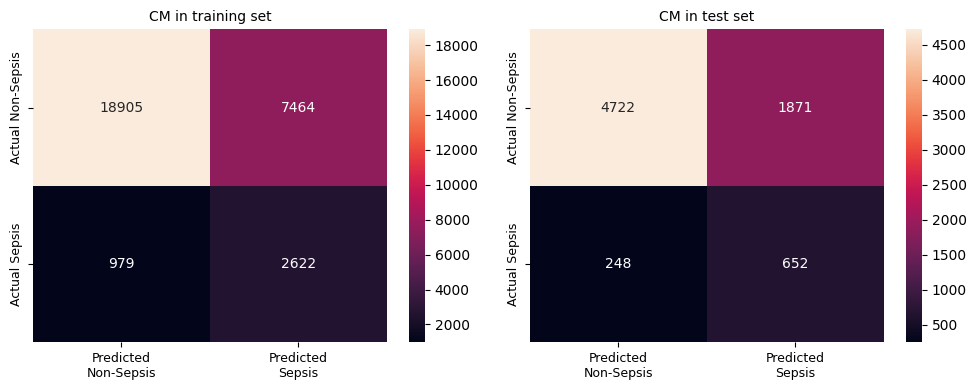

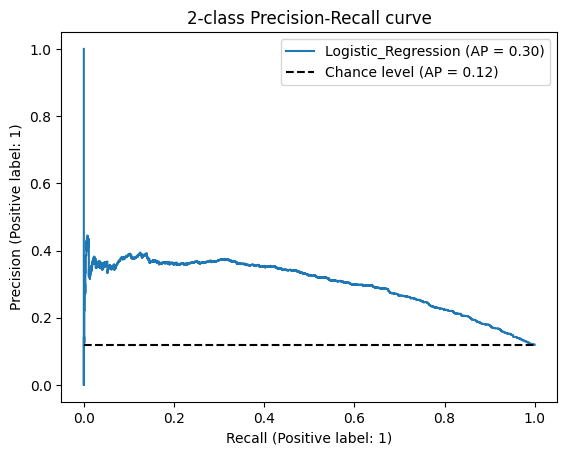

Logistic_Regression AUC : 0.7760


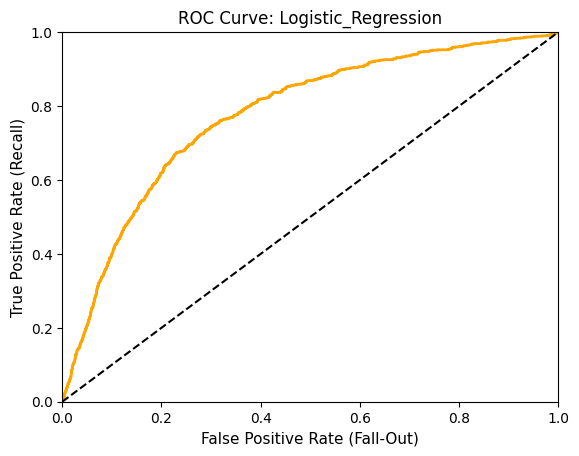

<Figure size 600x600 with 0 Axes>

Random_Forest
 ---------------------------------------- 


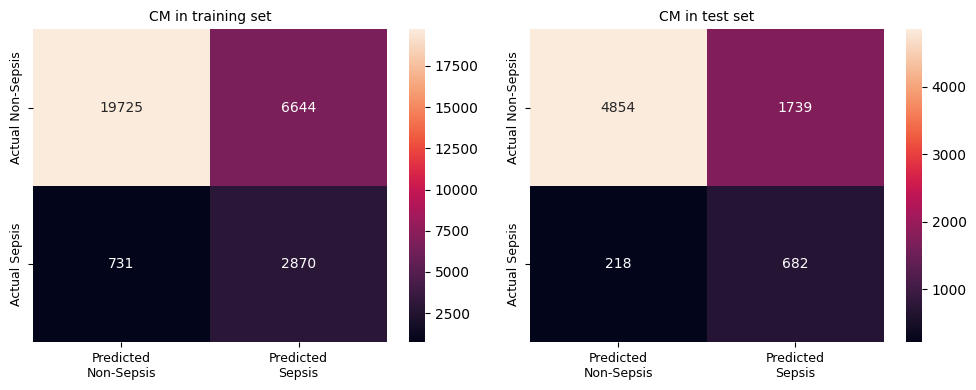

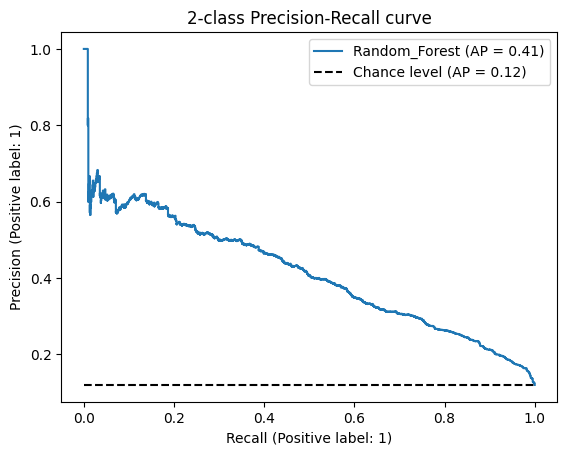

Random_Forest AUC : 0.8281


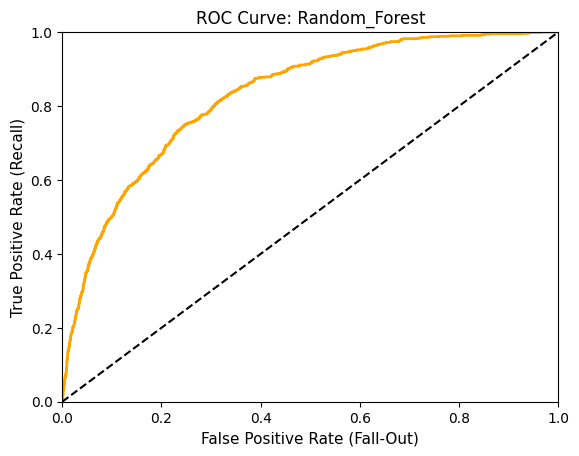

<Figure size 600x600 with 0 Axes>

Gradient_Boosting
 ---------------------------------------- 


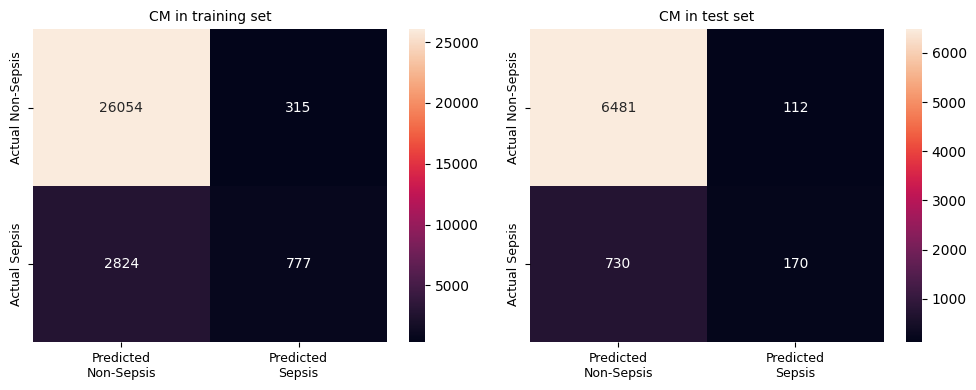

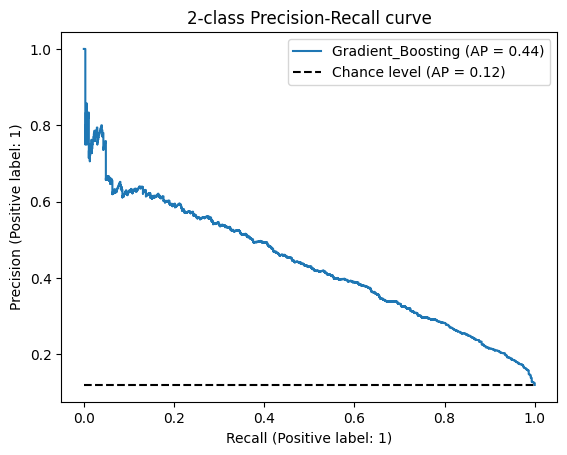

Gradient_Boosting AUC : 0.8383


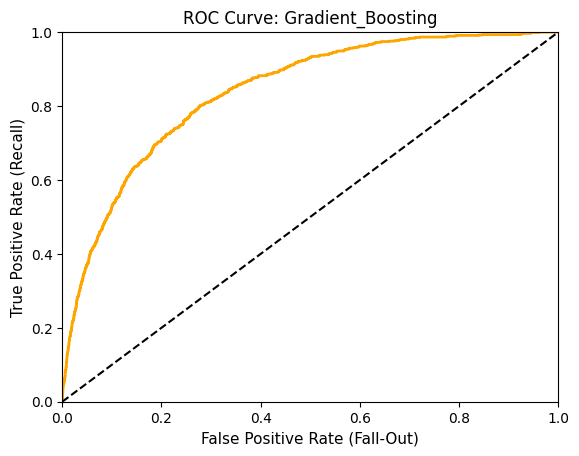

<Figure size 600x600 with 0 Axes>

In [31]:
# Visualise the model performance
mp.plot_results(final_candidate_model, top20_t2_class_weights, final_X_train, final_X_test, final_y_train, final_y_test)

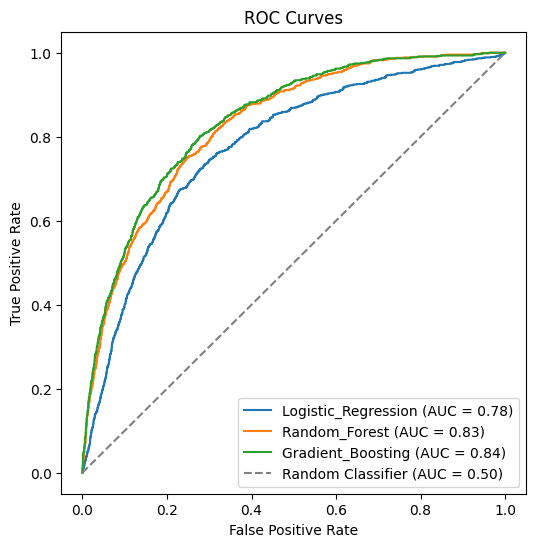

In [32]:
mp.plot_combined_roc_curves(final_candidate_model, final_X_test, final_y_test)

# 7. Feature Importance

### 7.1 SHAP

In [33]:
target_column = ["IS_SEPSIS"]
feature_columns = dfs_dict_without_missing['top20']['t2'].columns.drop("IS_SEPSIS").tolist()

# Convert 'ITEMID_' column to title
itemid_columns = [col for col in feature_columns if col.startswith('ITEMID_')]
title_mapping = dataLoader.convert_itemid_to_title(itemid_columns, df_desc_labitems)
for itemid, title in title_mapping.items():
    feature_columns[feature_columns.index(itemid)] = title

In [34]:
# Convert numpy array back to DataFrame
final_X_train_df = pd.DataFrame(final_X_train, columns=feature_columns)
final_y_train_df = pd.DataFrame(final_y_train, columns=target_column)
final_y_train_df = final_y_train_df.reset_index(drop=True)


final_X_test_df = pd.DataFrame(final_X_test, columns=feature_columns)
final_y_test_df = pd.DataFrame(final_y_test, columns=target_column)
final_y_test_df = final_y_test_df.reset_index(drop=True)

#### 7.1.1 Logistic Regression

##### 7.1.1.1 Global feature importance

In [35]:
explainer_lr = shap.LinearExplainer(final_candidate_model['Logistic_Regression'], final_X_train_df)
shap_values_lr = explainer_lr(final_X_test_df)

# set a display version of the data to use for plotting (has string values)
shap_values_lr.display_data = shap.datasets.adult(display=True)[0].values

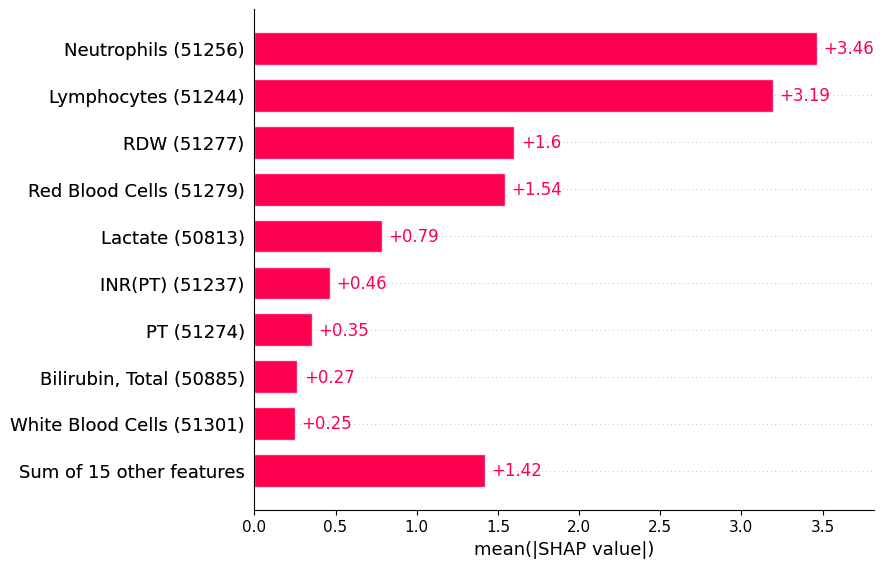

In [36]:
shap.plots.bar(shap_values_lr)

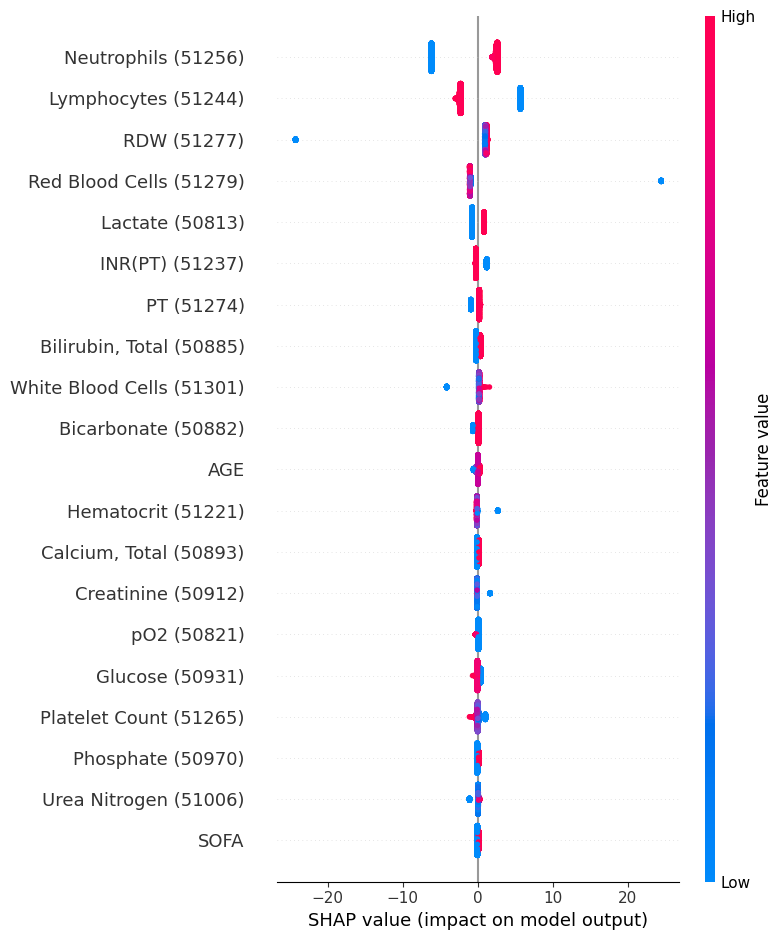

In [37]:
shap.summary_plot(shap_values_lr, final_X_test)

This plot shows the impact of each feature on the model output, as measured by SHAP value. The features are sorted from highest to lowest impact, so the most important features are at the top. The color of each bar indicates the impact on the model output, with red bars representing positive impacts and blue bars representing negative impacts.

- Positive impact: A feature has a positive impact on the model output if it increases the predicted value of the model.
- Negative impact: A feature has a negative impact on the model output if it decreases the predicted value of the model.

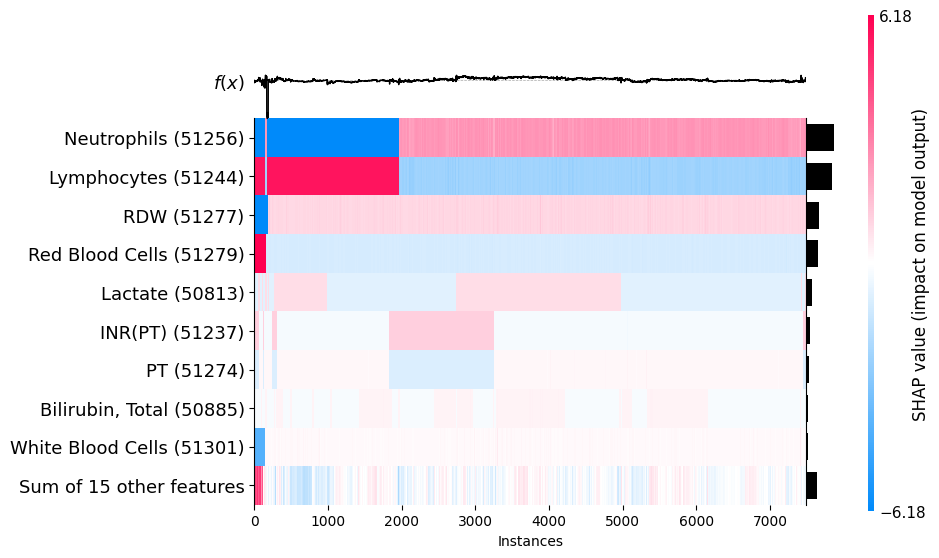

In [39]:
shap.plots.heatmap(shap_values_lr[:])

##### 7.1.1.2 Local Feature Importance

Sepsis Admission

In [38]:
# This will return a Series of boolean values (True where the condition is met, False otherwise)
condition = final_y_test_df['IS_SEPSIS'] == 1

# Display the indices where the condition is met
positive_indices = final_y_test_df[condition].index
print(positive_indices)

Index([   7,   17,   22,   30,   46,   51,   54,   56,   59,   69,
       ...
       7438, 7443, 7445, 7450, 7452, 7456, 7468, 7479, 7486, 7492],
      dtype='int64', length=900)


In [71]:
true_label_instance_1 = final_y_test_df.iloc[22]
print(true_label_instance_1)

IS_SEPSIS    1
Name: 22, dtype: int64


In [72]:
#22
individual_instance_1 = final_X_test_df.loc[[22]]
shap_values_lr_ind_1 = explainer_lr(individual_instance_1)
shap.initjs()
shap.force_plot(shap_values_lr_ind_1)

In [57]:
true_label_instance_2 = final_y_test_df.iloc[7468]
print(true_label_instance_2)

IS_SEPSIS    1
Name: 7468, dtype: int64


In [58]:
individual_instance_2 = final_X_test_df.loc[[7468]]
shap_values_lr_ind_2 = explainer_lr(individual_instance_2)
shap.initjs()
shap.force_plot(shap_values_lr_ind_2)

Non-Sepsis Admission

In [59]:
true_label_instance_3 = final_y_test_df.iloc[1314]
print(true_label_instance_3)

IS_SEPSIS    0
Name: 1314, dtype: int64


In [60]:
individual_instance_3 = final_X_test_df.loc[[1314]]
shap_values_lr_ind_3 = explainer_lr(individual_instance_3)
shap.initjs()
shap.force_plot(shap_values_lr_ind_3)

In [75]:
true_label_instance_4 = final_y_test_df.iloc[4782]
print(true_label_instance_4)

IS_SEPSIS    0
Name: 4782, dtype: int64


In [76]:
individual_instance_4 = final_X_test_df.loc[[4782]]
shap_values_lr_ind_4 = explainer_lr(individual_instance_4)
shap.initjs()
shap.force_plot(shap_values_lr_ind_4)

#### 7.1.2 Random Forest

##### 7.1.2.1 Global Feature Importance

In [40]:
explainer_rf = shap.TreeExplainer(final_candidate_model['Random_Forest']) 
shap_values_rf = explainer_rf.shap_values(final_X_test_df) 

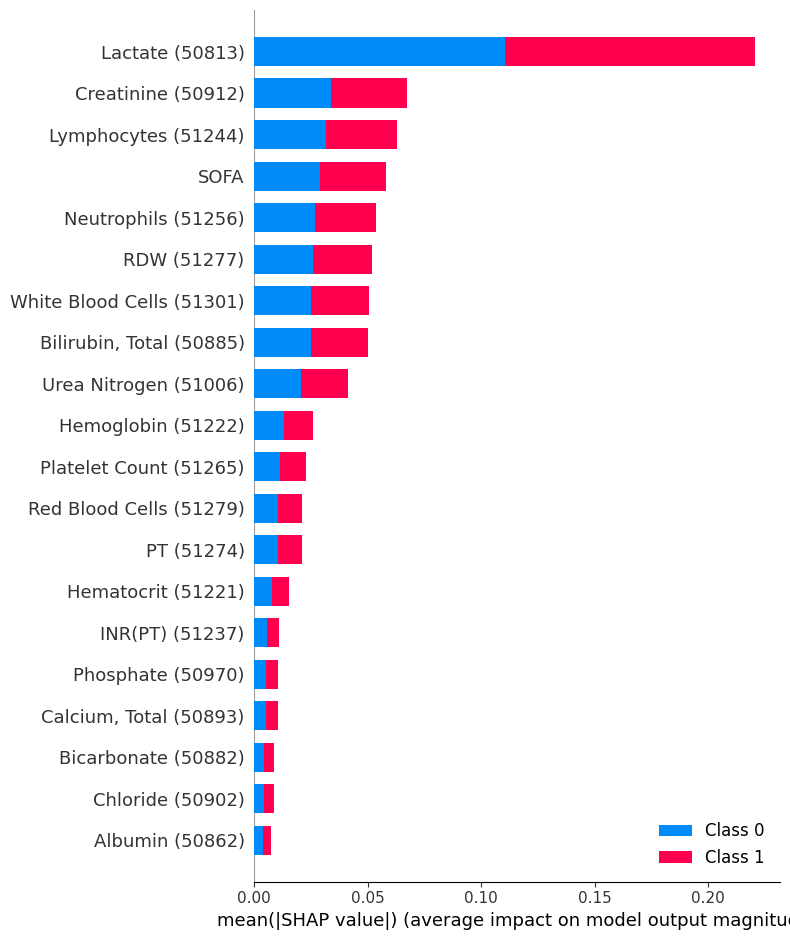

In [41]:
shap.summary_plot(shap_values_rf, final_X_test_df)

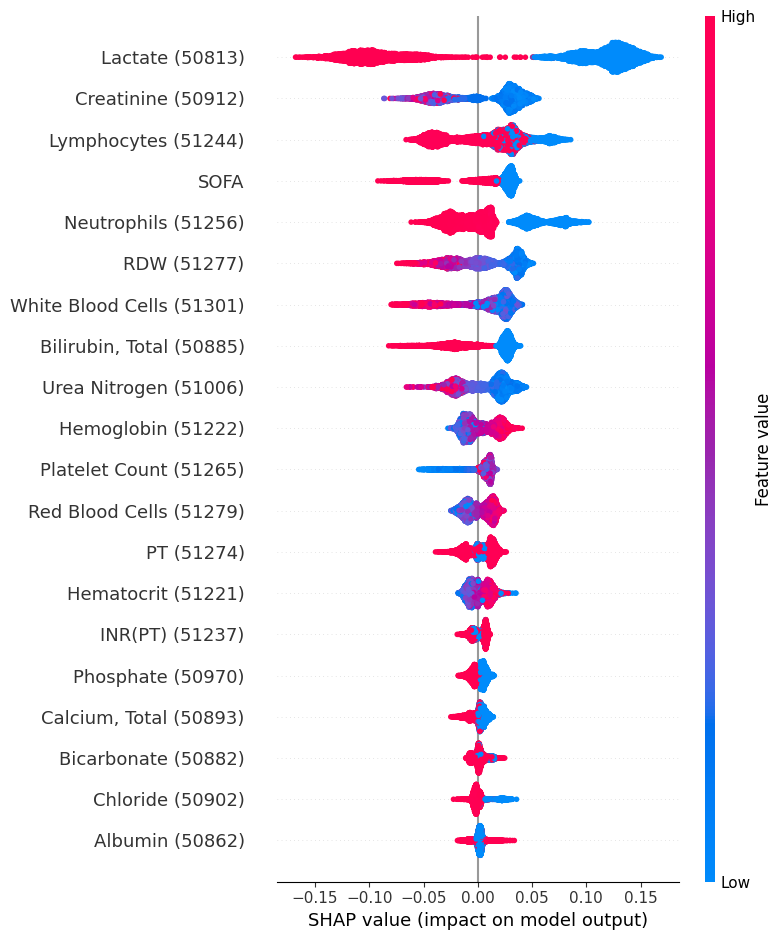

In [42]:
shap.summary_plot(shap_values_rf[0], final_X_test_df)

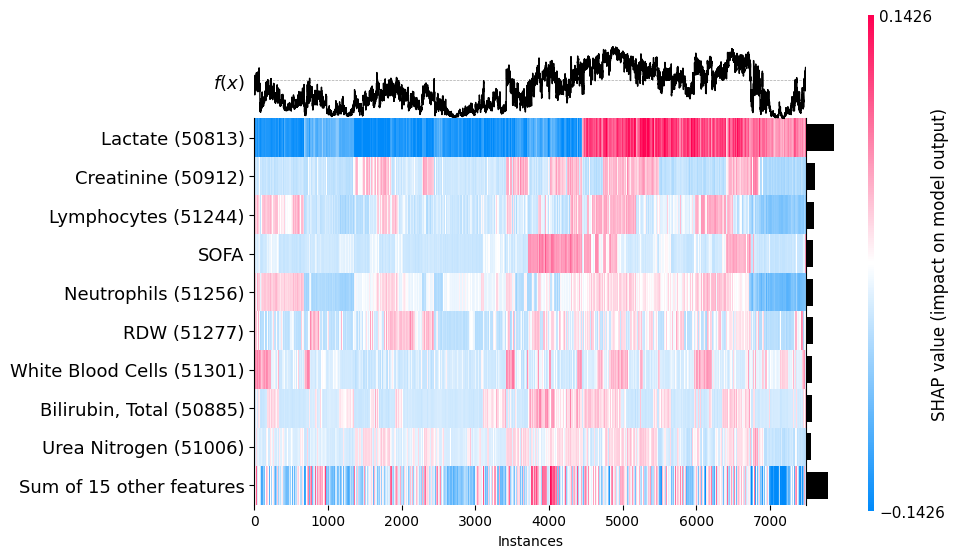

In [43]:
# Commented owing to significant time required to process (75min)
# shap_values_rf_subset = explainer_rf(final_X_test_df.iloc[:])
# shap.plots.heatmap(shap_values_rf_subset[:, :, 1])

##### 7.1.2.2 Local Feature Importance

Sepsis Admission

In [73]:
shap_values_rf_ind_1 = explainer_rf.shap_values(individual_instance_1)
shap.initjs()
shap.force_plot(explainer_rf.expected_value[1], shap_values_rf_ind_1[1], individual_instance_1)

In [64]:
shap_values_rf_ind_2 = explainer_rf.shap_values(individual_instance_2)
shap.initjs()
shap.force_plot(explainer_rf.expected_value[1], shap_values_rf_ind_2[1], individual_instance_2)

Non-spesis Admission

In [65]:
shap_values_rf_ind_3 = explainer_rf.shap_values(individual_instance_3)
shap.initjs()
shap.force_plot(explainer_rf.expected_value[1], shap_values_rf_ind_3[1], individual_instance_3)

In [77]:
shap_values_rf_ind_4 = explainer_rf.shap_values(individual_instance_4)
shap.initjs()
shap.force_plot(explainer_rf.expected_value[1], shap_values_rf_ind_4[1], individual_instance_4)

#### 7.1.3 Gradient Boosting

##### 7.1.3.1 Global Feature Importance

In [44]:
# compute SHAP values
explainer_gb = shap.TreeExplainer(final_candidate_model['Gradient_Boosting'])
shap_values_gb = explainer_gb(final_X_test_df)

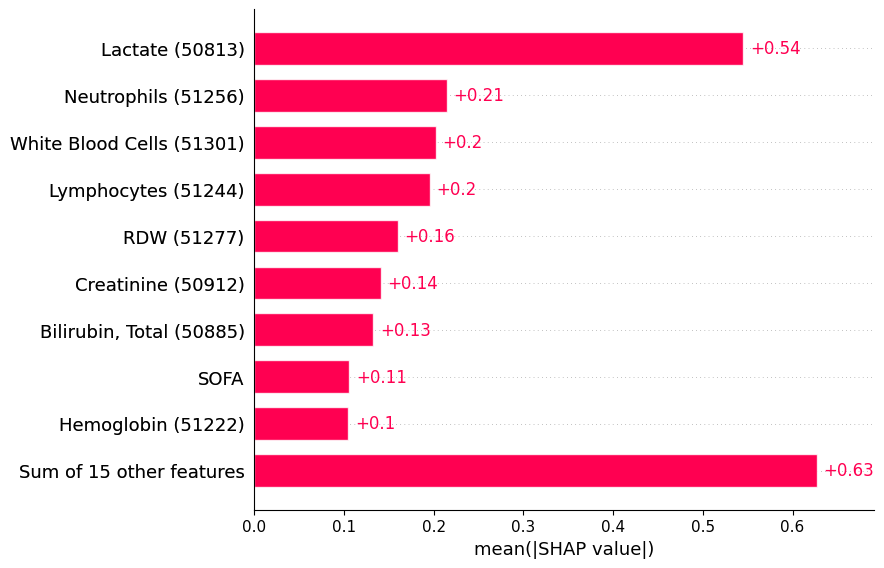

In [45]:
shap.plots.bar(shap_values_gb)

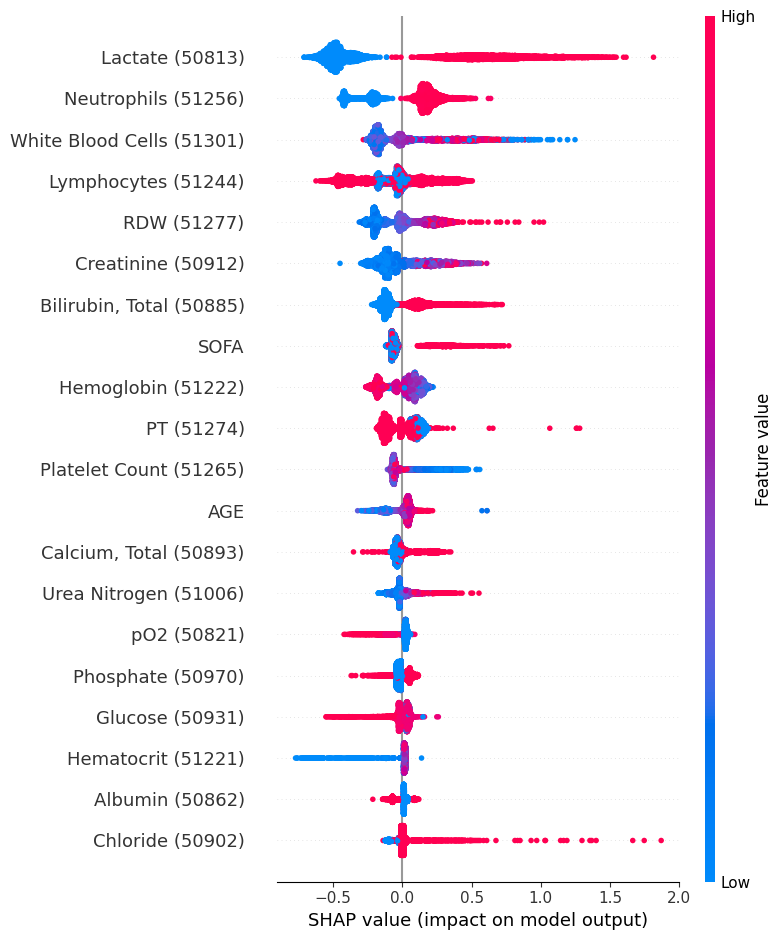

In [46]:
shap.summary_plot(shap_values_gb, final_X_test_df)

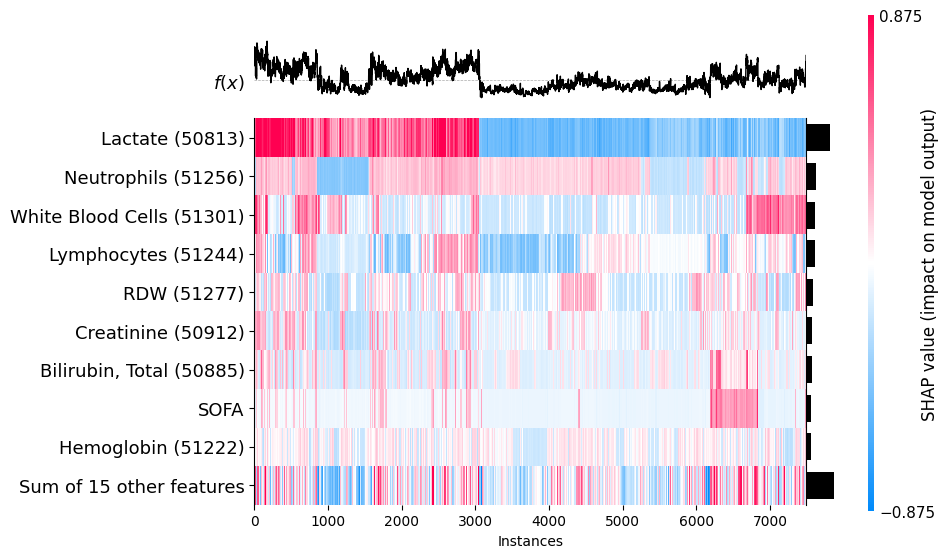

In [47]:
shap.plots.heatmap(shap_values_gb[:])

##### 7.1.3.2 Local Feature Importance

Sepsis Admission

In [74]:
shap_values_gb_ind_1 = explainer_gb(individual_instance_1)
shap.initjs()
shap.force_plot(shap_values_gb_ind_1)

In [68]:
shap_values_gb_ind_2 = explainer_gb(individual_instance_2)
shap.initjs()
shap.force_plot(shap_values_gb_ind_2)

Non-Sepsis Admission

In [69]:
shap_values_gb_ind_3 = explainer_gb(individual_instance_3)
shap.initjs()
shap.force_plot(shap_values_gb_ind_3)

In [78]:
shap_values_gb_ind_4 = explainer_gb(individual_instance_4)
shap.initjs()
shap.force_plot(shap_values_gb_ind_4)

# 8. Tuning Hyperparameters

From the above model evaluation, we have found Random Forest model performs the best among the 3 Traditional ML models. In this section, we will try to tune some of its hyperparameters in order to further improve its performance using GridSearch cross-validation.

In this case, we considered to tune 4 hyperparameters in Random Forest model:

- n_estimators (Number of trees in the forest): we tested for 50, 100 and 150

- max_depth (Maximum depth of the tree): we tested for None, 10 and 20

- min_samples_split (Minimum number of samples required to split an internal node): we tested for 2, 25, 50, 100 and 250

- min_samples_leaf (Minimum number of samples required to be at a leaf node): we tested for 2, 25, 50, 100 and 250

Our rationale behind this selection lies in ensuring robustness and preventing overfitting. By capping the highest number of samples necessary for an internal node split or to constitute a leaf node at roughly 5% of the dataset's total sepsis admissions, we aim to strike a balance between model complexity and its generalisability to new data.

Owing to the time and resources limitation in this project, we were unable to preform a more comprehensive GridSearch CV for hyperparameter tuning. We understood there may be more outperforming hyperparameter combination, a possible next step would be increasing the range of hyperparameters tuning. 

In [48]:
# code is comment since long processing time required (52min)
#best_params_rf = mp.tune_hyperparameters_rf(final_X_train, final_y_train, top20_t2_class_weights, final_candidate_model['Random_Forest'])

Best parameters: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 250, 'n_estimators': 50}
Best cross-validation score: 0.7550


From the above, we can observe the best combination to achieve the highest average validation balanced accuracy was:

n_estimators = 50, max_depth = 30, min_samples_split = 250 and min_samples_leaf = 2

We will apply this combination of hyperparameter to train our Random Forest model as follows.

In [84]:
final_dataset = dfs_dict_without_missing['top20']['t2']
final_dataset

AGE  IS_SEPSIS  GENDER_NUM  ITEMID_50813  ITEMID_50821  ITEMID_50862  \
0       64          0           1        -999.0        -999.0        -999.0   
4       58          0           0        -999.0        -999.0        -999.0   
8       72          0           0           1.4         148.0           2.7   
10      82          0           0           4.4        -999.0           3.9   
11      65          0           0        -999.0          53.0        -999.0   
...    ...        ...         ...           ...           ...           ...   
50692   80          1           1           1.8        -999.0           2.7   
50693   53          0           0           3.3        -999.0        -999.0   
50695   88          1           0           2.6         193.0        -999.0   
50696   19          0           1        -999.0         433.0        -999.0   
50697   83          0           1           3.5         227.0        -999.0   

       ITEMID_50882  ITEMID_50885  ITEMID_50893  ITEMID_50902  ...  \
0              28.0           0.4           9.1         103.0  ...   
4              23.0        -999.0        -999.0          95.0  ...   
8              27.0           0.9           8.2          95.0  ...   
10             25.0           0.7        -999.0         100.0  ...   
11             23.0        -999.0           8.9         105.0  ...   
...             ...           ...           ...           ...  ...   
50692          17.0           0.5           7.7         116.0  ...   
50693          24.0        -999.0        -999.0          94.0  ...   
50695        -999.0        -999.0        -999.0        -999.0  ...   
50696        -999.0        -999.0        -999.0        -999.0  ...   
50697        -999.0        -999.0        -999.0        -999.0  ...   

       ITEMID_51222  ITEMID_51237  ITEMID_51244  ITEMID_51256  ITEMID_51265  \
0              12.2           1.1          32.2          62.2         259.0   
4              13.1           1.0           9.5          84.6         269.0   
8              10.6           1.2        -999.0        -999.0         109.0   
10             14.7        -999.0           6.0          77.0         545.0   
11             13.7           1.1        -999.0        -999.0         299.0   
...             ...           ...           ...           ...           ...   
50692           9.6           1.1           8.7          88.5         164.0   
50693          13.7           1.4           1.0          73.0         195.0   
50695           9.3           2.3        -999.0        -999.0         184.0   
50696          13.9           1.0        -999.0        -999.0         241.0   
50697          14.8           1.0        -999.0        -999.0         271.0   

       ITEMID_51274  ITEMID_51277  ITEMID_51279  ITEMID_51301  SOFA  
0              12.4          12.6          4.00           5.1     2  
4              12.8          13.0          4.17          12.2  -999  
8              13.2          14.7          2.94           6.9     3  
10           -999.0          13.5          4.73          33.5     0  
11             12.3          13.5          4.55          11.1  -999  
...             ...           ...           ...           ...   ...  
50692          11.8          13.3          2.85          13.3     4  
50693          15.9          13.9          4.58          25.4  -999  
50695          24.1          15.8          3.41           6.2  -999  
50696          10.8          12.4          4.61           8.9  -999  
50697          11.8          14.1          5.03          30.3  -999  

[37463 rows x 25 columns]

In [87]:
final_dataset[final_dataset['IS_SEPSIS']==1]

AGE  IS_SEPSIS  GENDER_NUM  ITEMID_50813  ITEMID_50821  ITEMID_50862  \
18      75          1           0        -999.0        -999.0           2.7   
21      63          1           0        -999.0        -999.0        -999.0   
22      63          1           0           1.5        -999.0           2.9   
33      52          1           0        -999.0        -999.0        -999.0   
53      55          1           0        -999.0        -999.0           3.6   
...    ...        ...         ...           ...           ...           ...   
50659   45          1           0           1.8        -999.0        -999.0   
50668   84          1           1           1.0        -999.0        -999.0   
50673   69          1           0        -999.0        -999.0        -999.0   
50692   80          1           1           1.8        -999.0           2.7   
50695   88          1           0           2.6         193.0        -999.0   

       ITEMID_50882  ITEMID_50885  ITEMID_50893  ITEMID_50902  ...  \
18             21.0           1.3           8.4         106.0  ...   
21             25.0           0.5           9.5         104.0  ...   
22             20.0           0.2           8.8         132.0  ...   
33             27.0        -999.0        -999.0         103.0  ...   
53             23.0           0.9           8.6          99.0  ...   
...             ...           ...           ...           ...  ...   
50659          19.0           0.5           7.4         108.0  ...   
50668          20.0        -999.0        -999.0         106.0  ...   
50673          23.0           1.3           8.7         105.0  ...   
50692          17.0           0.5           7.7         116.0  ...   
50695        -999.0        -999.0        -999.0        -999.0  ...   

       ITEMID_51222  ITEMID_51237  ITEMID_51244  ITEMID_51256  ITEMID_51265  \
18             12.5           1.4        -999.0        -999.0          76.0   
21             10.5        -999.0          22.5          62.9          91.0   
22             10.1           1.4          14.8          76.3         109.0   
33           -999.0        -999.0        -999.0        -999.0        -999.0   
53              9.1        -999.0           2.0          90.0          24.0   
...             ...           ...           ...           ...           ...   
50659          11.5           1.4           2.0          70.0         644.0   
50668           7.7        -999.0           9.2          82.5         197.0   
50673          10.0           1.3           4.0          86.0         220.0   
50692           9.6           1.1           8.7          88.5         164.0   
50695           9.3           2.3        -999.0        -999.0         184.0   

       ITEMID_51274  ITEMID_51277  ITEMID_51279  ITEMID_51301  SOFA  
18             14.4          14.0          3.82          18.2     6  
21           -999.0          16.0          3.44           4.5     4  
22             15.9          14.9          3.00           5.0     5  
33           -999.0        -999.0       -999.00        -999.0  -999  
53           -999.0          19.8          2.81           1.6     4  
...             ...           ...           ...           ...   ...  
50659          16.0          16.4          4.21          24.7     1  
50668        -999.0          14.5          2.46           7.0  -999  
50673          15.1          17.5          3.53          16.9     5  
50692          11.8          13.3          2.85          13.3     4  
50695          24.1          15.8          3.41           6.2  -999  

[4501 rows x 25 columns]

# 9. Final Model Training

In [79]:
final_rf_model = {
    'Random_Forest': RandomForestClassifier(random_state=901,class_weight=top20_t2_class_weights, max_depth= 30, min_samples_leaf=2, min_samples_split=250, n_estimators=50),
    }

In [81]:
final_rf_performance_df = mp.static_models(final_rf_model, top20_t2_class_weights, final_X_train, final_y_train, final_X_test, final_y_test, 't3')
final_rf_performance_df 

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Model  Balanced_Acc_Train  Balanced_Acc_Test  Precision_Train  \
0  Random_Forest_t3            0.794389           0.755051           0.3307   

   Precision_Test  Recall_Train  Recall_Test  F1_Train   F1_Test  AUROC_Train  \
0        0.300446      0.813663     0.747778  0.470267  0.428662     0.881657   

   AUROC_Test  
0     0.83102

Random_Forest
 ---------------------------------------- 


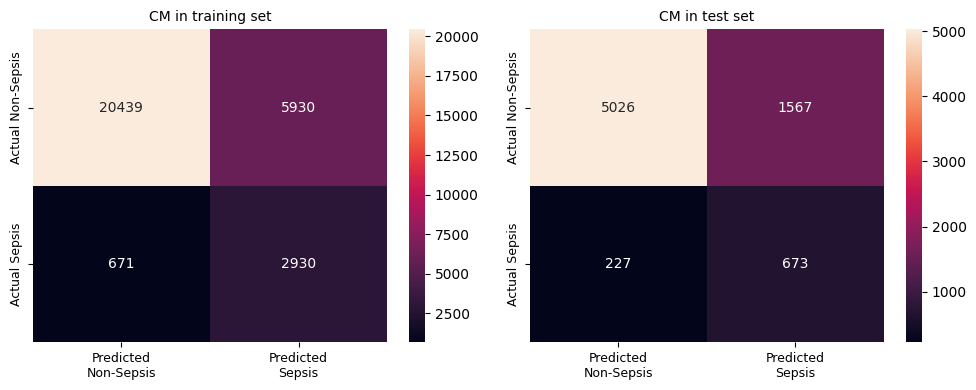

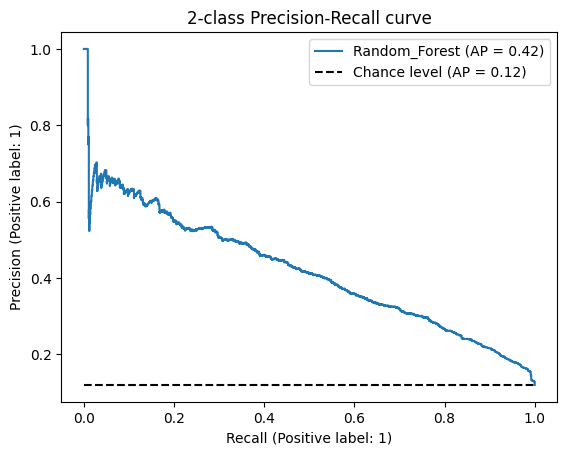

Random_Forest AUC : 0.8310


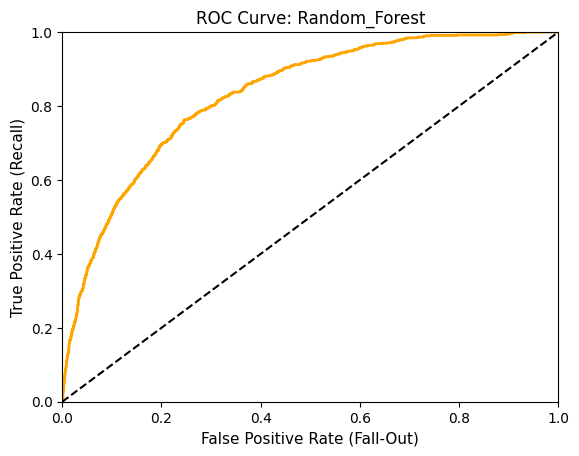

<Figure size 600x600 with 0 Axes>

In [88]:
# Visualise the model performance
mp.plot_results(final_rf_model, top20_t2_class_weights, final_X_train, final_X_test, final_y_train, final_y_test)

From the above, we observe there is no significant improvement in this hyperparameter tuned Random Forest model from our previous trained Random Forest model. We considered it is reasonable to keep the previous Random Forest model in our report. 

# 10. Ensemble Modeling

In order to further obtain improvement in our traditional (static) ML models, we have also considered applying ensemble modelling, which is powerful in combining the strengths and compensating for the weaknesses of individual models, thus potentially yielding better overall performance.

In [98]:
ensemble_models = [('rf', RandomForestClassifier(class_weight=top20_t2_class_weights, max_depth= 30, min_samples_leaf=2, min_samples_split=250)),
                    ('svc',AdaBoostClassifier()),
                    ('GBM',GradientBoostingClassifier())]


In [101]:
clf = StackingClassifier(ensemble_models, LogisticRegression())
clf = clf.fit(final_X_train, final_y_train)

In [102]:
balanced_accuracy_score(clf.predict(final_X_test),final_y_test)

0.7416988041675594

As compared to our Random Forest model trained in previous section (testing balanced accuracy = 0.747), there is no significant improvement noted in the ensemble model (testing balanced accuracy = 0.742). As a result, we believe the ensemble model may not be appropriate in this project. 

However, owing to the time and resources limitation in this project, we were unable to perform more trials in ensemble modelling, such as different combination of individual models with different hyperparameters tuned. We understood there may be more ourperforming ensemble models compared to our proposed Random Forest model. A possible next step would be performing more testing on the ensemble models with more powerful individual base models.

But for now, based on our evaluations, the Random Forest model seems to be the best performing traditional (static) ML model for this project.